# Сборный проект — 2 HR-аналитика компании «Работа с заботой»

<b>Описание проекта</b>

 HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

<b>Задачи проекта</b>

1. построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
2. построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

<b>Исходные данные</b>

<b>Задача 1</b>

Для этой задачи заказчик предоставил данные с признаками:
1. id — уникальный идентификатор сотрудника;
2. dept — отдел, в котором работает сотрудник;
3. level — уровень занимаемой должности;
4. workload — уровень загруженности сотрудника;
5. employment_years — длительность работы в компании (в годах);
6. last_year_promo — показывает, было ли повышение за последний год;
7. last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
8. supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
9. salary — ежемесячная зарплата сотрудника;
10. job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

<b>Задача 2</b>

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

<b>Шаги исследования</b>

<b>Задача 1</b>

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Подготовка данных
5. Обучение моделей
6. Оформление выводов

<b>Задача 2</b>

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Добавление нового входного признака
5. Подготовка данных
6. Обучение модели
7. Выводы

## Задача 1 предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [1]:
!pip install scikit-learn==1.6.1
!pip install shap -q
!pip -q install phik
!pip install matplotlib==3.5.1 -q
# !pip install lightgbm
# !pip install optuna


     |████████████████████████████████| 13.5 MB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 16.3 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
import phik
import shap
from lightgbm import LGBMClassifier


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
train_jsr =  pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features_jsr = pd.read_csv('/datasets/test_features.csv')
test_target_jsr = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [5]:
display(train_jsr.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
display(test_features_jsr.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [7]:
display(test_target_jsr.head())

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [8]:
train_jsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


train_jsr - типы данных соответствуют описанию, обнаружены незнавчительное количество пропусков данных в таких призенаках как  dept , level  - заполним их в будущем при помощи пайплайна

In [9]:
test_features_jsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


test_features_jsr - типы данных соответствуют описанию, обнаружены незнавчительное количество пропусков данных в таких призенаках как dept , level - заполним их в будущем при помощи пайплайна

In [10]:
test_target_jsr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


test_target_jsr - типы данных соответствуют описанию, не обнаружены пропуски в данных

#### Выводы

Мы загрузили необходимые для выполнения исследования билиотеки, а так же получили исходные данные.
Мы выявили, что : 
1. Названия столбцов не нужно менять
2. Все названия столбцов в трех таблицах одинаковы
3. Типы данных во всех датафреймах всех признаков совпадают с описанием.
4. Были выявлено незначительное количество пропусков в таких датафреймах как train_jsr, test_features_jsr в таких столбцах как dept , level ( категориальные данные) - данные пропуски заполним в будущем при помощи пайплайна, нет необходимости удалять их 

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно, первичный осмотр проведен.</font>

### Предобработка данных

#### Дубликаты

Неявные дубликаты

In [11]:
def get_unique_values(df):
    result = []

    for column in df.columns:
        if df[column].dtype == 'object':
            unique_values = list(df[column].unique())
            result.append({column: unique_values})
    print(result)

In [12]:
get_unique_values(train_jsr)
print()
get_unique_values(test_features_jsr)

[{'dept': ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]}, {'level': ['junior', 'middle', 'sinior', nan]}, {'workload': ['medium', 'high', 'low']}, {'last_year_promo': ['no', 'yes']}, {'last_year_violations': ['no', 'yes']}]

[{'dept': ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' ']}, {'level': ['junior', 'middle', 'sinior', nan]}, {'workload': ['medium', 'low', 'high', ' ']}, {'last_year_promo': ['no', 'yes']}, {'last_year_violations': ['no', 'yes']}]


Заменим значение в level с sinior на senior

In [13]:
train_jsr['level'].replace({'sinior': 'senior'}, inplace=True)
test_features_jsr['level'].replace({'sinior': 'senior'}, inplace=True)

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

In [14]:
get_unique_values(train_jsr)
print()
get_unique_values(test_features_jsr)

[{'dept': ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]}, {'level': ['junior', 'middle', 'senior', nan]}, {'workload': ['medium', 'high', 'low']}, {'last_year_promo': ['no', 'yes']}, {'last_year_violations': ['no', 'yes']}]

[{'dept': ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' ']}, {'level': ['junior', 'middle', 'senior', nan]}, {'workload': ['medium', 'low', 'high', ' ']}, {'last_year_promo': ['no', 'yes']}, {'last_year_violations': ['no', 'yes']}]


Неявных дубликатов не обнаружено

Посмотрим на явные дубликаты

In [15]:
print(train_jsr.duplicated().sum())
print(test_features_jsr.duplicated().sum())
print(test_target_jsr.duplicated().sum())

0
0
0


Так же не обнаружено и явных дубликатов

Посмотрим на распределение количества значений id

In [16]:
print(train_jsr['id'].value_counts())
print()
print(test_features_jsr['id'].value_counts())
print()
print(test_target_jsr['id'].value_counts())

296961    1
898488    1
783768    1
910746    1
613789    1
         ..
463527    1
862888    1
548638    1
624165    1
428031    1
Name: id, Length: 4000, dtype: int64

727043    1
340625    1
996005    1
356579    1
791203    1
         ..
683546    1
867647    1
314685    1
527675    1
200700    1
Name: id, Length: 2000, dtype: int64

727043    1
791203    1
836287    1
281278    1
404154    1
         ..
875851    1
230381    1
757063    1
628038    1
200700    1
Name: id, Length: 2000, dtype: int64


ID встречается всего один раз в каждом датафрейме - как и должно быть

#### Пропуски

train_jsr

In [17]:
display(train_jsr[train_jsr['dept'].isnull() | train_jsr['level'].isnull()])
print(f'Количество пропущенных значений после замены: \n {train_jsr.isna().sum()}')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Количество пропущенных значений после замены: 
 id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


test_features_jsr

In [18]:
get_unique_values(train_jsr)
print()
get_unique_values(test_features_jsr)

[{'dept': ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]}, {'level': ['junior', 'middle', 'senior', nan]}, {'workload': ['medium', 'high', 'low']}, {'last_year_promo': ['no', 'yes']}, {'last_year_violations': ['no', 'yes']}]

[{'dept': ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' ']}, {'level': ['junior', 'middle', 'senior', nan]}, {'workload': ['medium', 'low', 'high', ' ']}, {'last_year_promo': ['no', 'yes']}, {'last_year_violations': ['no', 'yes']}]


#### Вывод

train_jsr:

1. исправили орфографическую ошибку sinior на senior в столбце level
2. заметили, что есть пропуски , которые заменим в пайплайне с обучением модели


test_features_jsr:

1. исправили орфографическую ошибку sinior на senior в столбце level
2. заметили, что есть пропуски , которые заменим в пайплайне с обучением модели
3.  заметили, что есть пробелы (" "), которые заменим в пайплайне с обучением модели

test_target_jsr:

С датасетом все в порядке

### Исследовательский анализ данных

In [19]:
def display_categoral_distribution(df, column):
    value_counts = df[column].value_counts()
    display(value_counts)
    plt.figure(figsize=(8,6))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2", len(value_counts)))
    plt.title(f'Распределение значений признака {column}', fontsize=16)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
def display_quantitative_distribution(df, column, bins):
    display(df[column].describe())
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].hist(df[column], bins=bins, color='skyblue',edgecolor='black')
    axes[0].set_title(f'Рапределение значений признка {column}', fontsize=10)
    axes[0].set_xlabel(column, fontsize=14)
    axes[0].set_ylabel('Частота',fontsize=14)
    
    sns.boxplot(x=df[column], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'График с усами по признку {column}', fontsize=10)
    axes[1].set_xlabel(column, fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
def display_discrete_distribution(df, column):
    value_counts = df[column].value_counts().sort_index()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title(f'Распределение значений признака {column}', fontsize=10)
    axes[0].set_xlabel(column, fontsize=14)
    axes[0].set_ylabel('Частота', fontsize=14)

    sns.boxplot(x=df[column], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'График с усами по признаку {column}', fontsize=10)
    axes[1].set_xlabel(column, fontsize=14)

    plt.tight_layout()
    plt.show()

Проведем иследовательский анализ данных только на тренировочной выборке, т.к. основная цель тестовой выборки — проверка производительности модели на новых, незнакомых данных. Любое вмешательство в тестовую выборку, включая анализ, может повлиять на оценку точности модели и привести к утечке данных, что нарушит объективность оценки.

In [20]:
display(train_jsr.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


#### dept

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

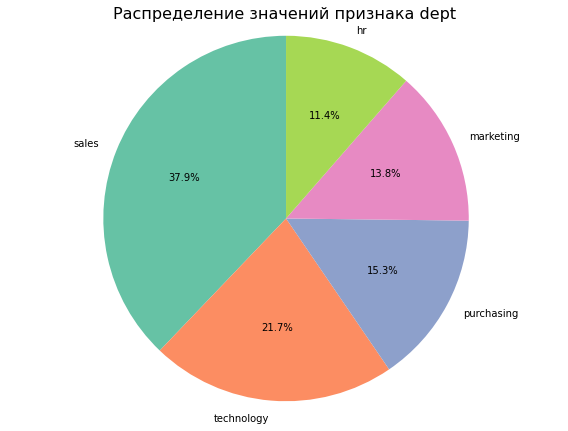

In [21]:
display_categoral_distribution(train_jsr,'dept')

Таким образом, большенство объектов работают в отделе sales (38%), остальные отделы распределены следующим образом technology (21.6%), purchasing (15.3%), marketing (13.8%), hr (11.4%)

#### level

junior    1894
middle    1744
senior     358
Name: level, dtype: int64

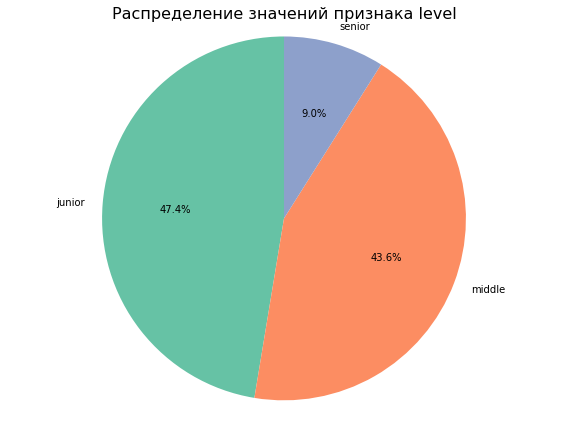

In [22]:
display_categoral_distribution(train_jsr,'level')

Таким образом, большенство объектов имеют уровень junior (47.5%) либо уровень middle (43.6%), совсем небольшое количество объектов имеет уровень senior (9%)

#### workload

medium    2066
low       1200
high       734
Name: workload, dtype: int64

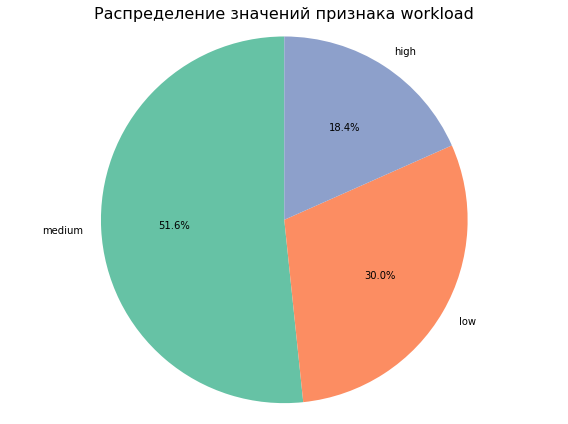

In [23]:
display_categoral_distribution(train_jsr,'workload')

Таким образом, почти половина объектов имеют ворклоуд medium (51.6%) , остальные имеют ворклоуд low (30%) либо же high ( 18.4%)

#### last_year_promo

no     3880
yes     120
Name: last_year_promo, dtype: int64

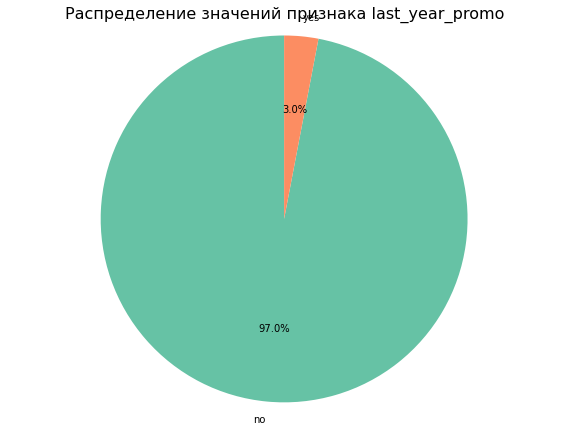

In [24]:
display_categoral_distribution(train_jsr,'last_year_promo')

Таким образом, можно заметить, что почти все объекты не имели повышения в прошлом году, и лишь 3% имели повышение в прошлом году

#### last_year_violations

no     3441
yes     559
Name: last_year_violations, dtype: int64

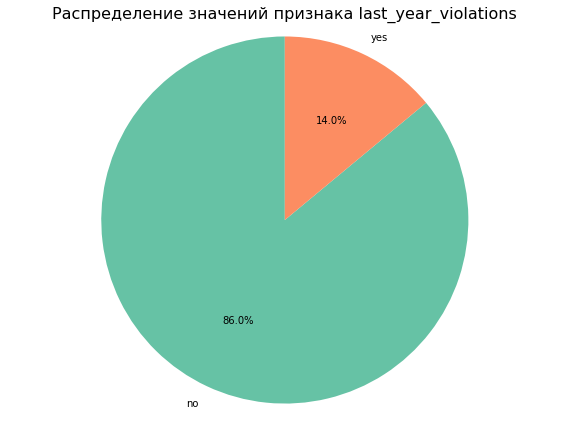

In [25]:
display_categoral_distribution(train_jsr,'last_year_violations')

Таким образом, можно заметить, что большенство объектов (86%) не имели нарушений, и  14% имели нарушения в прошлом году

#### employment_years

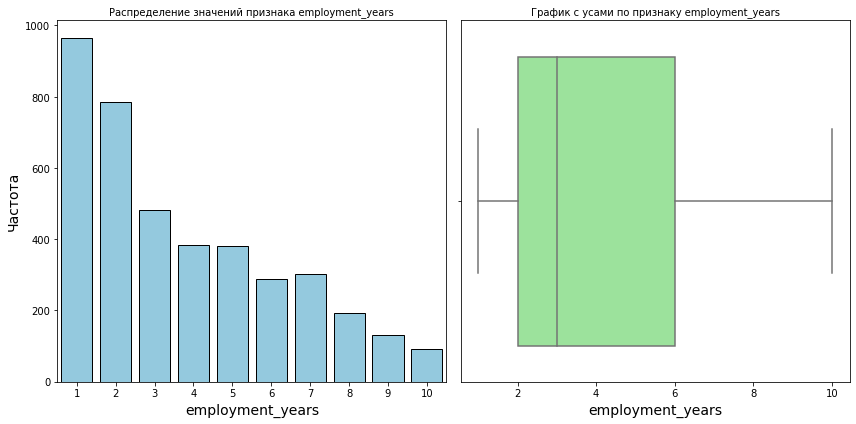

In [26]:
display_discrete_distribution(train_jsr,'employment_years')

В компании практически в 2 раза больше сотрудников, которые работают в ней до 3х лет: опытных сотрудников гораздо меньше. Стоит учесть это при переборе параметров для модели в дальнейшем

#### supervisor_evaluation

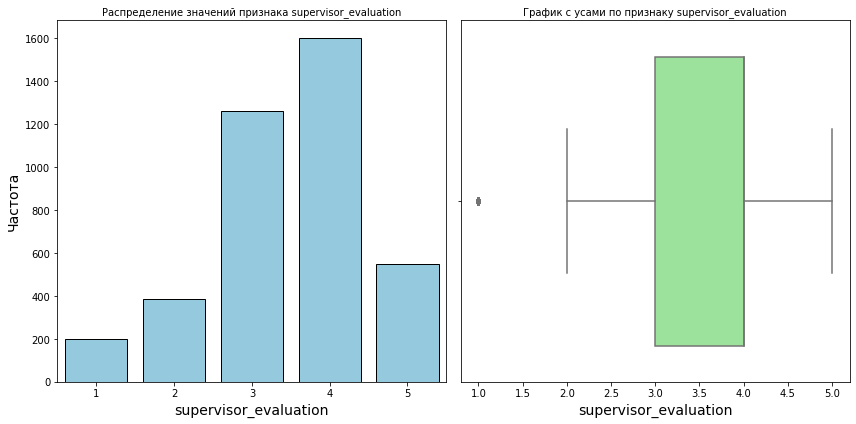

In [27]:
display_discrete_distribution(train_jsr,'supervisor_evaluation')

Большенство объектов имеет оценку 4 или 3, так же видно что оценку 1 ставят редко, однако она тоже встречается

#### salary

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

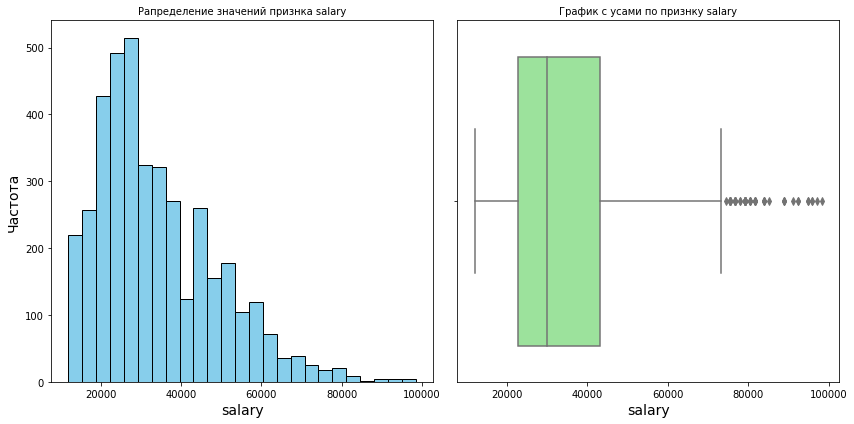

In [28]:
display_quantitative_distribution(train_jsr,'salary', 25)

Медианная зарпалата составляет 30,000, болшенство данных распределено в промежутке от 22,800 до 43,200. 
Средняя зарпалата больше медианной на почти 4000. Так же видны выбросы справа - вероятно, это высокие зарплаты у малочисленных объектов с уровнем senior. Посмотрим на распределение зарплат по уровню 

junior

count     1894.000000
mean     24200.211193
std       7250.917566
min      12000.000000
25%      19200.000000
50%      24000.000000
75%      28800.000000
max      48000.000000
Name: salary, dtype: float64

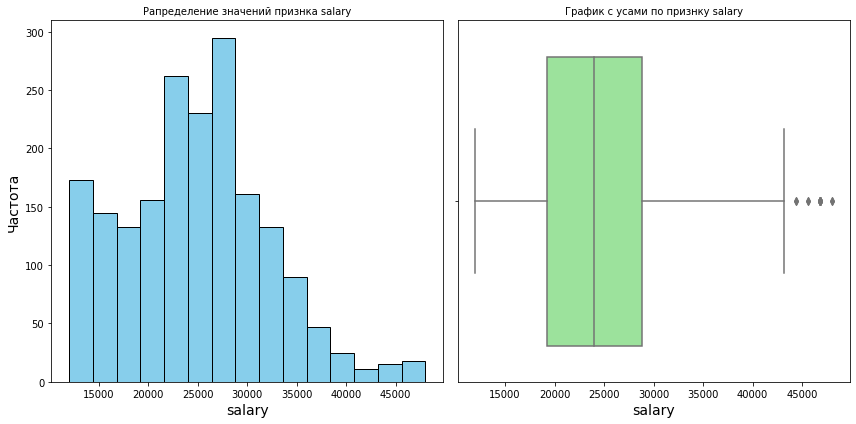

In [29]:
display_quantitative_distribution(train_jsr.query('level == "junior"'),'salary', 15)

middle

count     1744.000000
mean     39714.220183
std      12256.406929
min      18000.000000
25%      30000.000000
50%      39600.000000
75%      48300.000000
max      69600.000000
Name: salary, dtype: float64

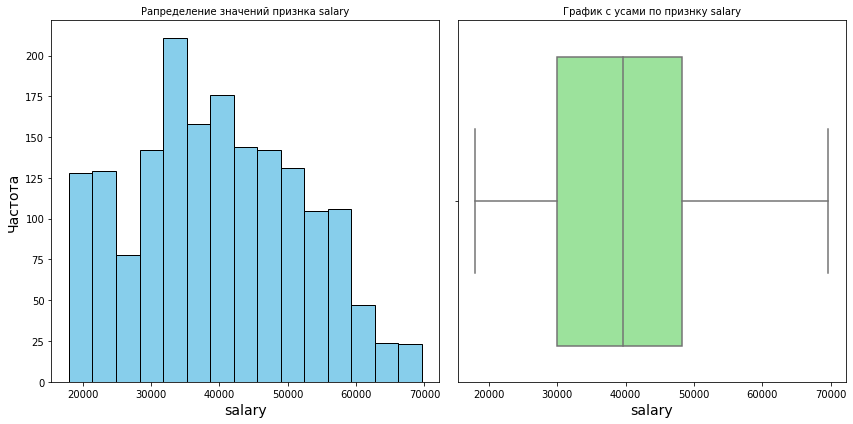

In [30]:
display_quantitative_distribution(train_jsr.query('level == "middle"'),'salary', 15)

senior

count      358.000000
mean     57291.620112
std      16150.263837
min      25200.000000
25%      45600.000000
50%      56400.000000
75%      69600.000000
max      98400.000000
Name: salary, dtype: float64

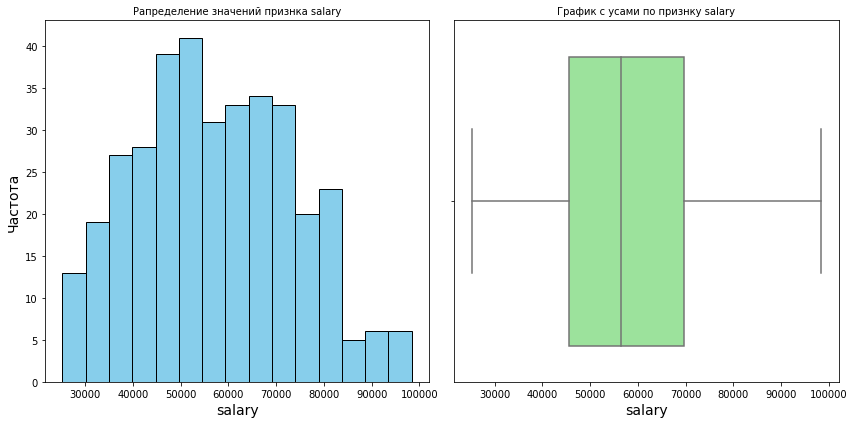

In [31]:
display_quantitative_distribution(train_jsr.query('level == "senior"'),'salary', 15)

Заметим, что существуют выбросы справа у уровня junior. Рост медианной зарплаты с ростом уровня является логичным

Посмотрим на распределение зарплат у уровня junior по отделам 

sales

count      697.000000
mean     22066.571019
std       6282.592159
min      12000.000000
25%      18000.000000
50%      21600.000000
75%      26400.000000
max      38400.000000
Name: salary, dtype: float64

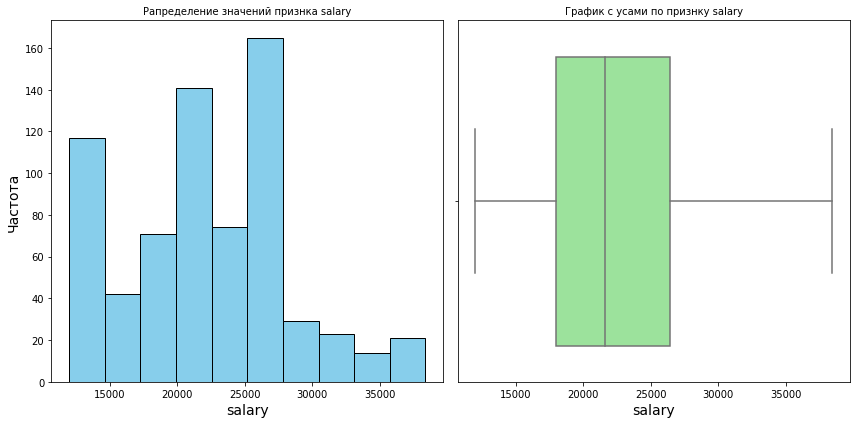

In [32]:
display_quantitative_distribution(train_jsr.query('(level == "junior") & (dept == "sales")'),'salary', 10)

technology

count      410.000000
mean     28340.487805
std       8202.758780
min      14400.000000
25%      22800.000000
50%      27600.000000
75%      33600.000000
max      48000.000000
Name: salary, dtype: float64

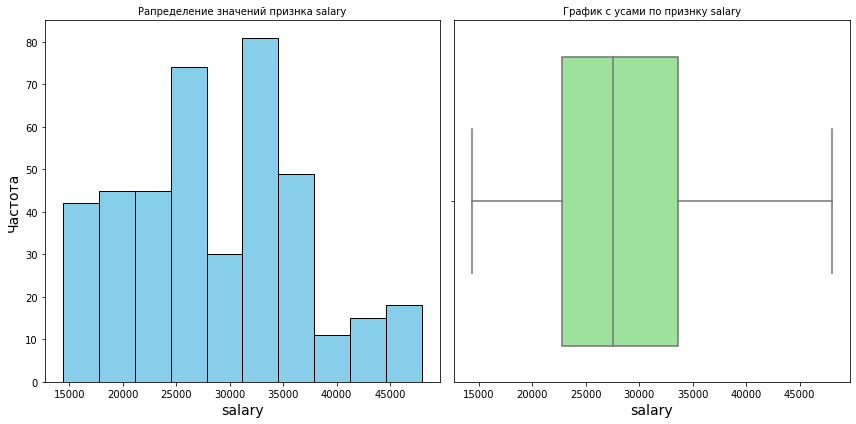

In [33]:
display_quantitative_distribution(train_jsr.query('(level == "junior") & (dept == "technology")'),'salary', 10)

purchasing

count      293.000000
mean     23827.986348
std       6513.119140
min      12000.000000
25%      19200.000000
50%      24000.000000
75%      28800.000000
max      40800.000000
Name: salary, dtype: float64

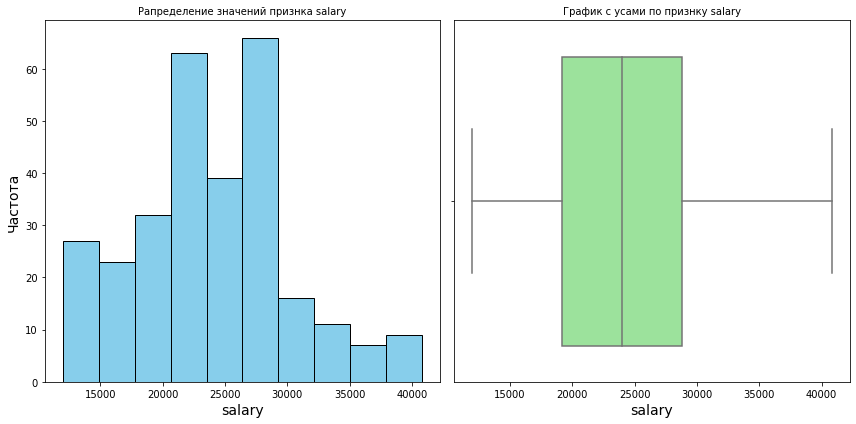

In [34]:
display_quantitative_distribution(train_jsr.query('(level == "junior") & (dept == "purchasing")'),'salary', 10)

marketing

count      270.000000
mean     24315.555556
std       6943.509356
min      13200.000000
25%      18000.000000
50%      24000.000000
75%      28800.000000
max      43200.000000
Name: salary, dtype: float64

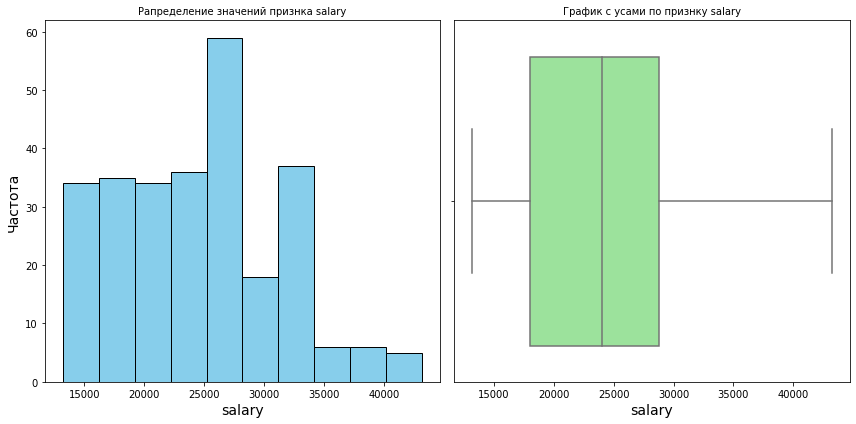

In [35]:
display_quantitative_distribution(train_jsr.query('(level == "junior") & (dept == "marketing")'),'salary', 10)

hr

count      218.000000
mean     23647.706422
std       6302.184485
min      12000.000000
25%      19200.000000
50%      24000.000000
75%      28800.000000
max      40800.000000
Name: salary, dtype: float64

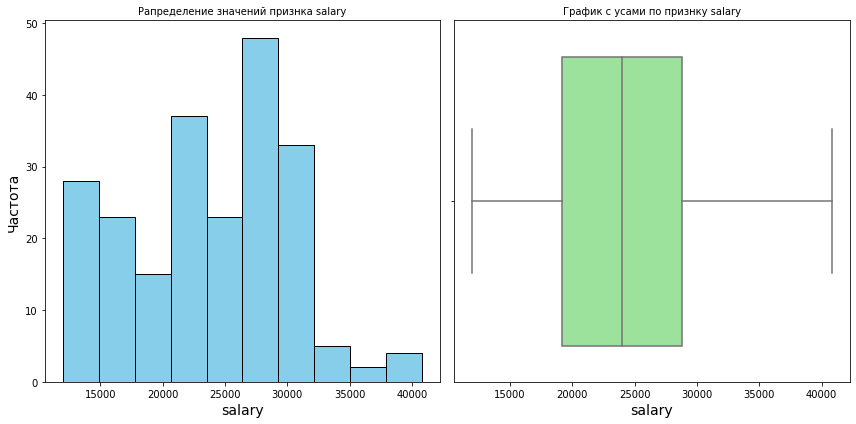

In [36]:
display_quantitative_distribution(train_jsr.query('(level == "junior") & (dept == "hr")'),'salary', 10)

Выбросов по отделам не замчено, посмотрим на распределение медианной зарплаты по уровням и отделам 

In [37]:
pivot_table = train_jsr.pivot_table(
    index='dept',            
    columns='level',         
    values='salary',         
    aggfunc='median',        
    fill_value=0             
)
display(pivot_table)

level,junior,middle,senior
dept,,,
hr,24000,39600,54000
marketing,24000,40800,55200
purchasing,24000,38400,57600
sales,21600,38400,51600
technology,27600,44400,64800


Таким образом, видим, что медианная зарплата растет с ростом уровня во всех отделах - что является обосновонным, а так же "стартовая" медианная зарплата выше в отделе technology, чем в других отделах, так же медианная зарплата в данном отделе выше и на ругих уровнях. что и показывает выбрросы на общем графике распределения запрлат в компании. По этому не будем удалять данные выбросы 

Таким образом, медианная зарплата в компании составляет 30,000, болшенство данных распределено в промежутке от 22,800 до 43,200. Средняя зарпалата больше медианной на почти 34,000. Данные зарплаты распределены нормально со мещением влево. Чем выше уровень объекта, тем выше заработная плата. Самая большая медианная зарплата в отделе technology, самая маленькая - в отедле sales

<span style="color: blue; font-weight: bold">Комментарий ревьюера : </span> ✔️\
<span style="color: green"> 👍</span>

#### job_satisfaction_rate

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

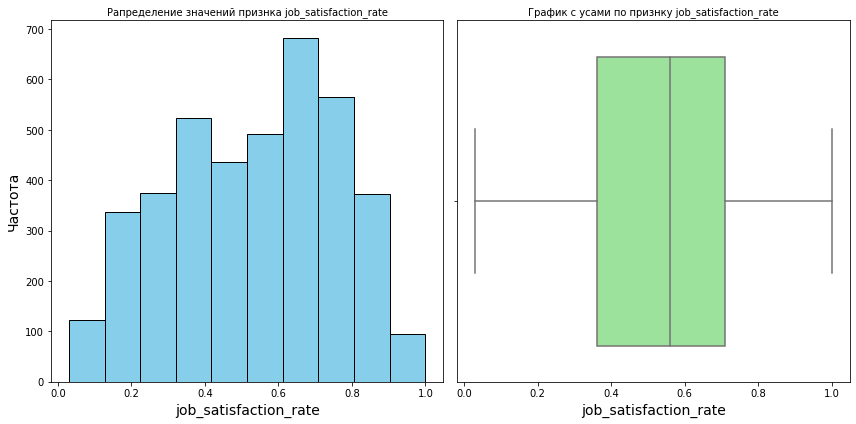

In [38]:
display_quantitative_distribution(train_jsr,'job_satisfaction_rate', 10)

Данные целевого признака распределены нормально,  с медианным значеннием равным 0.56 и средним 0.53, большенство данных распределено в промежутке от 0.36 до 0.71.

#### Корреляционный анализ

interval columns not set, guessing: ['id', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']


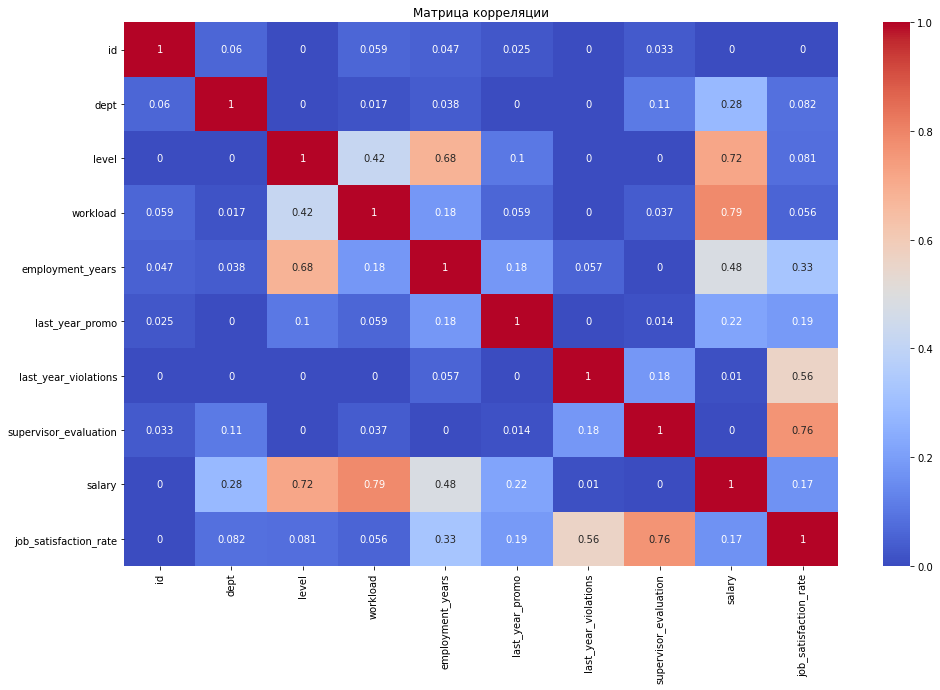

In [39]:
corr_matrix = train_jsr.phik_matrix()
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Заметимя, что целевой признак имеет следующие зависимости:
1. очень сильная зависимость с признаком - supervisor_evaluation (0.76)
2. сильная зависимость с признаком  - last_year_violations (0.56)
3. - умеренная зависимость с признаком - employment_years (0.33)
4. слабая зависимость с признаком - last_year_promo(0.19), salary (0.17)
5. Не наблюдается связи со следующими признаками - dept, level, workload

Так же между входными признаками наблюдаются следующие сильные зависимости: 
1. salary - workload ( 0.79)
2. salary - level ( 0.72) 
3. emplayment_year - level ( 0.68) 
Так как данные коофициенты коорреляуии меньше 0.9 - то мультиколлениарность не наблюдается 

#### dept_test

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

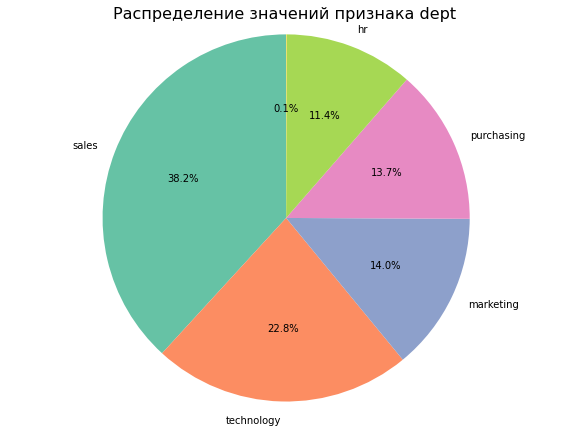

In [40]:
display_categoral_distribution(test_features_jsr,'dept')

Заметим, что данный признак в тестовой выборке в целом распределен также, как и в тренировочной 

####  level_test

junior    974
middle    854
senior    171
Name: level, dtype: int64

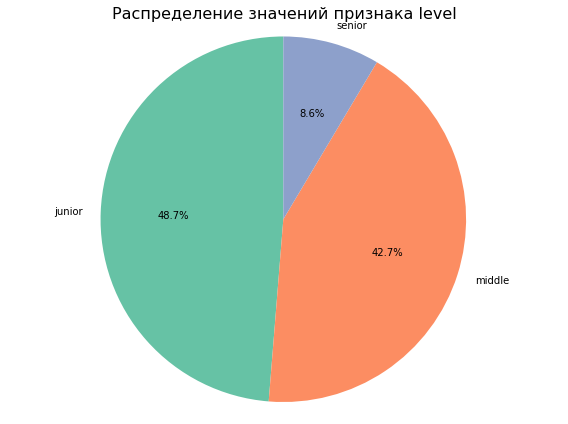

In [41]:
display_categoral_distribution(test_features_jsr,'level')

Заметим, что данный признак в тестовой выборке в целом распределен также, как и в тренировочной 

#### workload_test

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

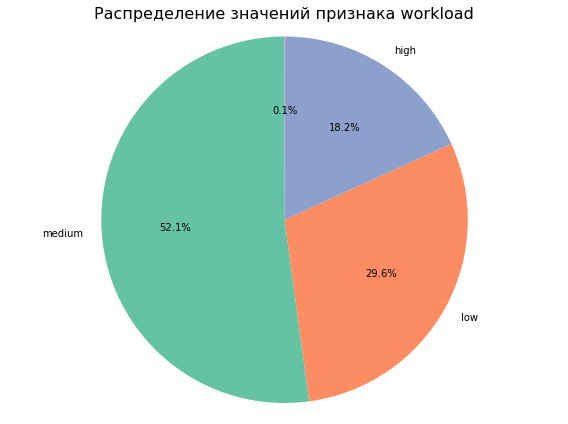

In [42]:
display_categoral_distribution(test_features_jsr,'workload')

Заметим, что данный признак в тестовой выборке в целом распределен также, как и в тренировочной 

last_year_promo

no     1937
yes      63
Name: last_year_promo, dtype: int64

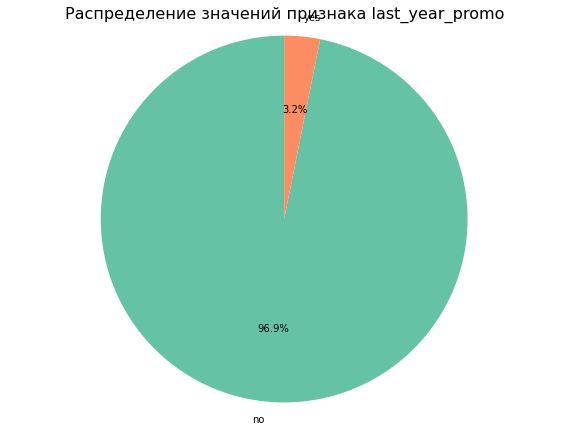

In [43]:
display_categoral_distribution(test_features_jsr,'last_year_promo')

Заметим, что данный признак в тестовой выборке в целом распределен также, как и в тренировочной 

#### last_year_violations_test

no     1738
yes     262
Name: last_year_violations, dtype: int64

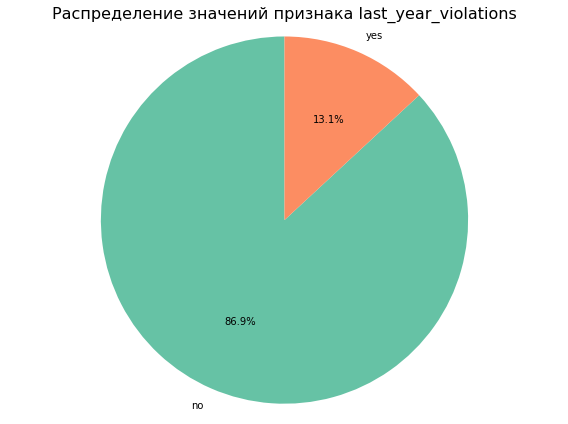

In [44]:
display_categoral_distribution(test_features_jsr,'last_year_violations')

Заметим, что данный признак в тестовой выборке в целом распределен также, как и в тренировочной 

####  employment_years_test

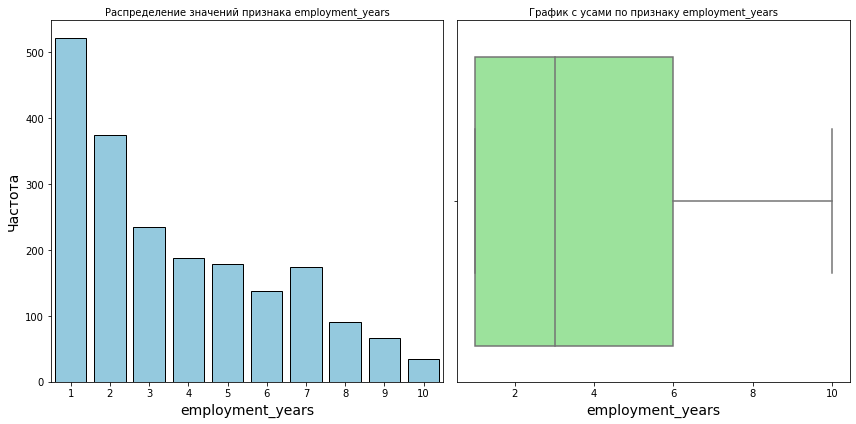

In [45]:
display_discrete_distribution(test_features_jsr,'employment_years')

Заметим, что данный признак в тестовой выборке в целом распределен также, как и в тренировочной 

####  supervisor_evaluation_test

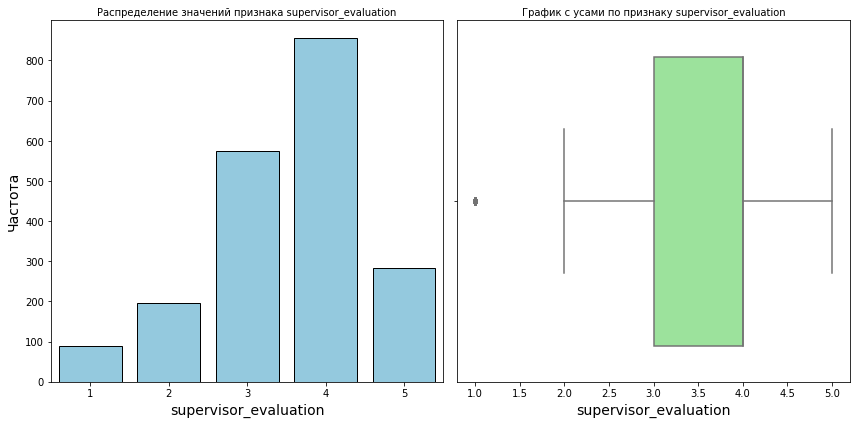

In [46]:
display_discrete_distribution(test_features_jsr,'supervisor_evaluation')

Заметим, что данный признак в тестовой выборке в целом распределен также, как и в тренировочной 

#### salary_test

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

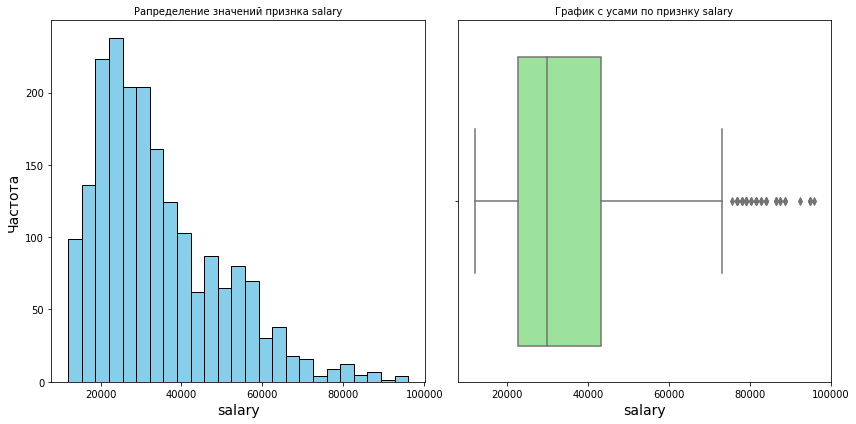

In [47]:
display_quantitative_distribution(test_features_jsr,'salary', 25)

Заметим, что данный признак в тестовой выборке в целом распределен также, как и в тренировочной 

#### job_satisfaction_rate_test

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

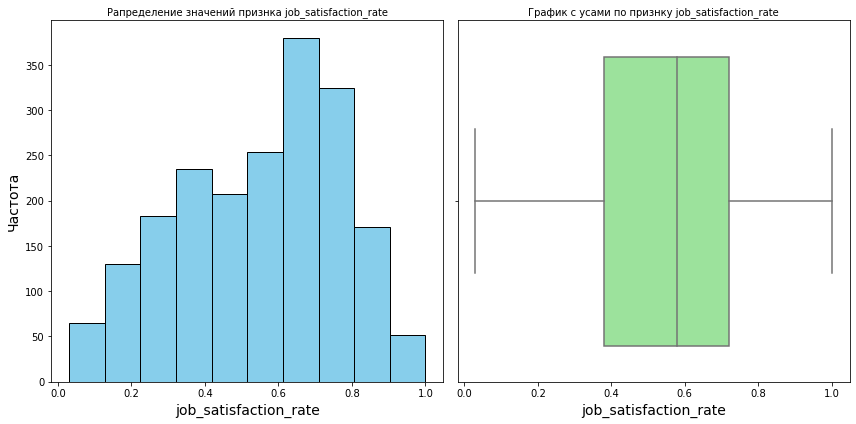

In [48]:
display_quantitative_distribution(test_target_jsr,'job_satisfaction_rate', 10)

Заметим, что данный признак в тестовой выборке в целом распределен также, как и в тренировочной 

#### Вывод

Мы провели исследовательский анализ данных и заметили, что: 
1. dept - большенство объектов работают в отделе sales (38%), остальные отделы распределены следующим образом technology (21.6%), purchasing (15.3%), marketing (13.8%), hr (11.4%)
2. level - большенство объектов имеют уровень junior (47.5%) либо уровень middle (43.6%), совсем небольшое количество объектов имеет уровень senior (9%)
3. workload - половина объектов имеют ворклоуд medium (51.6%) , остальные имеют ворклоуд low (30%) либо же high ( 18.4%)
4. last_year_promo - почти все объекты не имели повышения в прошлом году, и лишь 3% имели повышение в прошлом году
5. last_year_violations - большенство объектов (86%) не имели нарушений, и  14% имели нарушения в прошлом году
6. employmant_years - в компании практически в 2 раза больше сотрудников, которые работают в ней до 3х лет: опытных сотрудников гораздо меньше. Стоит учесть это при переборе параметров для модели в дальнейшем
7. supervisor_evaluation - большенство объектов имеет оценку 4 или 3, так же видно что оценку 1 ставят редко, однако она тоже встречается
8. salary - медианная зарплата в компании составляет 30,000, болшенство данных распределено в промежутке от 22,800 до 43,200. Средняя зарпалата больше медианной на почти 34,000. Данные зарплаты распределены нормально со мещением влево. Чем выше уровень объекта, тем выше заработная плата. Самая большая медианная зарплата в отделе technology, самая маленькая - в отедле sales
9. job_satisfaction_rate - целевой признака распределены нормально,  с медианным значеннием равным 0.56 и средним 0.53, большенство данных распределено в промежутке от 0.36 до 0.71.

Так же мы провели корреляционный анализ и заметили, что целевой признак имеет следующие зависимости:
1. очень сильная зависимость с признаком - supervisor_evaluation (0.76)
2. сильная зависимость с признаком  - last_year_violations (0.56)
3. - умеренная зависимость с признаком - employment_years (0.33)
4. слабая зависимость с признаком - last_year_promo(0.19), salary (0.17)
5. Не наблюдается связи со следующими признаками - dept, level, workload

Так же между входными признаками наблюдаются следующие сильные зависимости: 
1. salary - workload ( 0.79)
2. salary - level ( 0.72) 
3. emplayment_year - level ( 0.68) 
Так как данные коофициенты коорреляуии меньше 0.9 - то мультиколлениарность не наблюдается 

Так же мы провели исследовательский анализ данных признаков тестовых данных и установили, что данные в тестовых данных распределены в целом также, как и данные признаков в тренировочной выборке


### Подготовка данных

In [49]:
display(train_jsr)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


In [50]:
train_1 = train_jsr.set_index('id')

Посмотрим, есть ли дубликаты признаков без учета  id 

In [51]:
print(train_1.duplicated().sum())

245


 </span><br><span style="color: purple; font-weight: bold">Комментарий студента</span>
Убрал удаление дубликатов только входных признаков и удалил дубликаты связки входных признаков и целевого без id

Удалим данные 245 дубликатов с заменой айди на айди первого вхождения

In [52]:
train_1 = train_1.drop_duplicates()
display(train_1.head())
print(train_1.shape)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


(3755, 9)


Таким образом у нас осталось 3755 строк данных для обучения без дубликатов 

#### Создадим датафреймы для обучения модели

In [53]:
X_train_1 = train_1.drop('job_satisfaction_rate', axis=1)
display(X_train_1.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000
653870,hr,junior,high,2,no,no,5,38400
184592,sales,junior,low,1,no,no,2,12000
171431,technology,junior,low,4,no,no,2,18000
693419,hr,junior,medium,1,no,no,3,22800


In [54]:
y_train_1 = train_1['job_satisfaction_rate']
display(y_train_1.head())

id
155278    0.58
653870    0.76
184592    0.11
171431    0.37
693419    0.20
Name: job_satisfaction_rate, dtype: float64

In [55]:
X_test_1 = test_features_jsr.set_index('id')
y_test_1 = test_target_jsr.set_index('id')

In [56]:
full_test =X_test_1.merge(y_test_1, right_index=True, left_index=True)
display(full_test)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.56
109582,technology,middle,low,3,no,no,2,21600,0.14
305653,technology,junior,low,1,no,no,3,14400,0.11


In [57]:
print(full_test['job_satisfaction_rate'].isna().sum())

0


In [58]:
y_test_1 = full_test['job_satisfaction_rate']
X_test_1 = full_test.drop('job_satisfaction_rate', axis=1)
display(y_test_1.head())
display(X_test_1.head())

id
485046    0.79
686555    0.72
467458    0.64
418655    0.60
789145    0.75
Name: job_satisfaction_rate, dtype: float64

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


Таким образом, мы создали обучающие датафреймы X_test_1, y_test_1 , а так же для тестирования моделей, созданные на основе полученных файлов, y_test_1, X_test_1

#### Создание пайплайнов

Для большинства категориальных признаков применим для кодирования OneHotEncoder Для признаков level и workload применем OrdinalEncoder

In [59]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']


ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])


### Обучение моделей

#### Создание собственной метрики

Выбор будем делать на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). Успехом будет считаться значение метрики SMAPE меньше 15 на тестовой выборке.

In [60]:
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
    return np.mean(diff) * 100

smape_score = make_scorer(smape, greater_is_better=False)

#### Подбор гиперпараметров 

Будем рассматривать такие модели, как линейная регрессия, дерево решений

In [61]:
param_randomized_test = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]


randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_randomized_test, 
    cv=5,
    scoring=smape_score,
    n_jobs=-1,  
    random_state=RANDOM_STATE
)

randomized_search.fit(X_train_1, y_train_1)

current_best_model = randomized_search.best_estimator_['models']
predictions_test = randomized_search.best_estimator_.predict(X_test_1)
current_train_score = (-1) * randomized_search.best_score_
current_test_score = smape(y_test_1, predictions_test)

print(current_best_model)
print('SMAPE лучшей модели на кросс-валидации по обучающей выборке:', current_train_score)
print(f'SMAPE на тестовой выборке: {current_test_score}')
print()

DecisionTreeRegressor(max_depth=12, max_features=8, random_state=42)
SMAPE лучшей модели на кросс-валидации по обучающей выборке: 15.859813742642888
SMAPE на тестовой выборке: 14.212648779981658



/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучшая модель по итогу перебора -DecisionTreeRegressor(max_depth=12, max_features=8, random_state=42)
SMAPE на тестовой выборке - 14.212648779981658- что удовлетворяет успеху

In [62]:
cv_results = randomized_search.cv_results_
results_df = pd.DataFrame(cv_results)

results_df['model'] = results_df['params'].apply(lambda x: x.get('models', None))
results_df['preprocessing'] = results_df['params'].apply(lambda x: x.get('preprocessor__num', None))

results_df['smape'] = -results_df['mean_test_score']  

results_df_sorted = results_df.sort_values(by='smape', ascending=True)

display(results_df_sorted[['model', 'preprocessing', 'smape', 'params']])


,model,preprocessing,smape,params
7,DecisionTreeRegressor(random_state=42),MinMaxScaler(),15.859814,"{'preprocessor__num': MinMaxScaler(), 'models_..."
8,DecisionTreeRegressor(random_state=42),MinMaxScaler(),15.945380,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,DecisionTreeRegressor(random_state=42),StandardScaler(),16.168915,"{'preprocessor__num': StandardScaler(), 'model..."
3,DecisionTreeRegressor(random_state=42),StandardScaler(),16.369336,"{'preprocessor__num': StandardScaler(), 'model..."
0,DecisionTreeRegressor(random_state=42),passthrough,16.468337,"{'preprocessor__num': 'passthrough', 'models__..."
2,DecisionTreeRegressor(random_state=42),StandardScaler(),17.509407,"{'preprocessor__num': StandardScaler(), 'model..."
6,DecisionTreeRegressor(random_state=42),passthrough,17.512321,"{'preprocessor__num': 'passthrough', 'models__..."
4,DecisionTreeRegressor(random_state=42),StandardScaler(),19.440155,"{'preprocessor__num': StandardScaler(), 'model..."
5,DecisionTreeRegressor(random_state=42),StandardScaler(),20.611883,"{'preprocessor__num': StandardScaler(), 'model..."
9,DecisionTreeRegressor(random_state=42),StandardScaler(),20.987823,"{'preprocessor__num': StandardScaler(), 'model..."


#### Анализ важности признаков

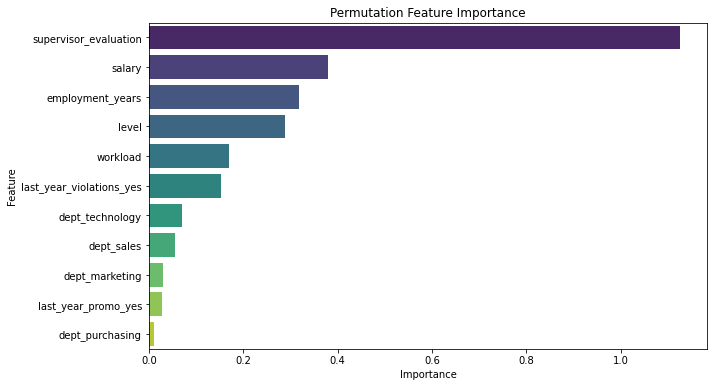

In [63]:
best_model = randomized_search.best_estimator_
X_train_transformed = best_model.named_steps['preprocessor'].transform(X_train_1)

perm_importance = permutation_importance(best_model.named_steps['models'], X_train_transformed, y_train_1, n_repeats=10, random_state=42)

importance_values = perm_importance.importances_mean
importance_std = perm_importance.importances_std

feature_names = []

if hasattr(best_model.named_steps['preprocessor'].transformers_[0][1], 'get_feature_names_out'):
    ohe_feature_names = best_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(ohe_columns)
    feature_names.extend(ohe_feature_names)

if hasattr(best_model.named_steps['preprocessor'].transformers_[1][1], 'get_feature_names_out'):
    ord_feature_names = ord_columns  
    feature_names.extend(ord_feature_names)

if hasattr(best_model.named_steps['preprocessor'].transformers_[2][1], 'get_feature_names_out'):
    num_feature_names = best_model.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out()
    feature_names.extend(num_feature_names)

passthrough_columns = best_model.named_steps['preprocessor'].transformers_[3][2] if len(best_model.named_steps['preprocessor'].transformers_) > 3 else []
feature_names.extend(passthrough_columns)

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_values,
    'Std': importance_std
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Permutation Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Заметим, что самыми важными признаками, которые больше всего влияют на определение моделью JSR являются: 
1. supervisor_evalustion
2. salary
3. employment_years
4. level
5. workload
6. last_year_viloations_yes
7. dept

#### Выводы

Мы создали свою метрику для оценки моделей — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). Успехом будет считаться значение метрики SMAPE меньше 15 на тестовой выборке.

Будем рассматривать такие модели, как линейная регрессия, дерево решений

Лучшая модель по итогу перебора -DecisionTreeRegressor(max_depth=12, max_features=8, random_state=42)
SMAPE на тестовой выборке - 14.212648779981658- что удовлетворяет успеху

Заметим, что самыми важными признаками, которые больше всего влияют на определение моделью JSR являются: 
1. supervisor_evalustion
2. salary
3. employment_years
4. level
5. workload
6. last_year_viloations_yes
7. dept

### Вывод

Мы загрузили необходимые для выполнения исследования билиотеки, а так же получили исходные данные.
Мы выявили, что : 
1. Названия столбцов не нужно менять
2. Все названия столбцов в трех таблицах одинаковы
3. Типы данных во всех датафреймах всех признаков совпадают с описанием.
4. Были выявлено незначительное количество пропусков в таких датафреймах как train_jsr, test_features_jsr в таких столбцах как dept , level ( категориальные данные) - данные пропуски заполним в будущем при помощи пайплайна, нет необходимости удалять их 

Мы провели предобработку данных и выявили, что 
train_jsr:

1. исправили орфографическую ошибку sinior на senior в столбце level
2. заметили, что есть пропуски , которые заменим в пайплайне с обучением модели
test_features_jsr:

1. исправили орфографическую ошибку sinior на senior в столбце level
2. заметили, что есть пропуски , которые заменим в пайплайне с обучением модели
3.  заметили, что есть пробелы (" "), которые заменим в пайплайне с обучением модели

test_target_jsr:

С датасетом все в порядке

Мы провели иследовательский анализ данных, и выявили, что: 

Мы провели исследовательский анализ данных и заметили, что: 
1. dept - большенство объектов работают в отделе sales (38%), остальные отделы распределены следующим образом technology (21.6%), purchasing (15.3%), marketing (13.8%), hr (11.4%)
2. level - большенство объектов имеют уровень junior (47.5%) либо уровень middle (43.6%), совсем небольшое количество объектов имеет уровень senior (9%)
3. workload - половина объектов имеют ворклоуд medium (51.6%) , остальные имеют ворклоуд low (30%) либо же high ( 18.4%)
4. last_year_promo - почти все объекты не имели повышения в прошлом году, и лишь 3% имели повышение в прошлом году
5. last_year_violations - большенство объектов (86%) не имели нарушений, и  14% имели нарушения в прошлом году
6. employmant_years - в компании практически в 2 раза больше сотрудников, которые работают в ней до 3х лет: опытных сотрудников гораздо меньше. Стоит учесть это при переборе параметров для модели в дальнейшем
7. supervisor_evaluation - большенство объектов имеет оценку 4 или 3, так же видно что оценку 1 ставят редко, однако она тоже встречается
8. salary - медианная зарплата в компании составляет 30,000, болшенство данных распределено в промежутке от 22,800 до 43,200. Средняя зарпалата больше медианной на почти 34,000. Данные зарплаты распределены нормально со мещением влево. Чем выше уровень объекта, тем выше заработная плата. Самая большая медианная зарплата в отделе technology, самая маленькая - в отедле sales
9. job_satisfaction_rate - целевой признака распределены нормально,  с медианным значеннием равным 0.56 и средним 0.53, большенство данных распределено в промежутке от 0.36 до 0.71.

Так же мы провели корреляционный анализ и заметили, что целевой признак имеет следующие зависимости:
1. очень сильная зависимость с признаком - supervisor_evaluation (0.76)
2. сильная зависимость с признаком  - last_year_violations (0.56)
3. - умеренная зависимость с признаком - employment_years (0.33)
4. слабая зависимость с признаком - last_year_promo(0.19), salary (0.17)
5. Не наблюдается связи со следующими признаками - dept, level, workload

Так же между входными признаками наблюдаются следующие сильные зависимости: 
1. salary - workload ( 0.79)
2. salary - level ( 0.72) 
3. emplayment_year - level ( 0.68) 
Так как данные коофициенты коорреляуии меньше 0.9 - то мультиколлениарность не наблюдается 

Так же мы провели исследовательский анализ данных признаков тестовых данных и установили, что данные в тестовых данных распределены в целом также, как и данные признаков в тренировочной выборке


Мы провели подготовку данных и обучение моделей, и выявили, что: 
Мы создали свою метрику для оценки моделей — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). Успехом будет считаться значение метрики SMAPE меньше 15 на тестовой выборке.


Будем рассматривать такие модели, как линейная регрессия, дерево решений

Лучшая модель по итогу перебора -DecisionTreeRegressor(max_depth=12, max_features=8, random_state=42)
SMAPE на тестовой выборке - 14.212648779981658- что удовлетворяет успеху

Заметим, что самыми важными признаками, которые больше всего влияют на определение моделью JSR являются: 
1. supervisor_evalustion
2. salary
3. employment_years
4. level
5. workload
6. last_year_viloations_yes
7. dept


## Задача 2 предсказание увольнения сотрудника из компании

### Загрузка данных

In [64]:
train_quit =  pd.read_csv('/datasets/train_quit.csv')
X_test_2 = test_features_jsr
y_test_2 = pd.read_csv('/datasets/test_target_quit.csv')

In [65]:
display(train_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [66]:
display(X_test_2.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [67]:
display(y_test_2.head())

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [68]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


Пропуски в данных не обнаружены, типы данных соответствуют описанию

In [69]:
X_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Пропуски в данных не обнаружены, типы данных соответствуют описанию

In [70]:
y_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Пропуски в данных не обнаружены, типы данных соответствуют описанию

#### Выводы

Мы получили исходные данные для решения второй задачи, для тестовой выборки входных признаков использован датафрейм из первой задачи ( в виду этого пропустим предобработку данных для этого датафрейма) 
Мы выявили, что : 
1. Названия столбцов не нужно менять
2. Все названия столбцов в трех таблицах одинаковы
3. Типы данных во всех датафреймах всех признаков совпадают с описанием.
4. Пропусков данных не обнарудено

### Предобработка данных

#### Дубликаты

In [71]:
get_unique_values(train_quit)

[{'dept': ['sales', 'purchasing', 'marketing', 'technology', 'hr']}, {'level': ['middle', 'junior', 'sinior']}, {'workload': ['high', 'medium', 'low']}, {'last_year_promo': ['no', 'yes']}, {'last_year_violations': ['no', 'yes']}, {'quit': ['no', 'yes']}]


In [72]:
train_quit['level'].replace({'sinior': 'senior'}, inplace=True)

In [73]:
get_unique_values(train_quit)
get_unique_values(y_test_2)

[{'dept': ['sales', 'purchasing', 'marketing', 'technology', 'hr']}, {'level': ['middle', 'junior', 'senior']}, {'workload': ['high', 'medium', 'low']}, {'last_year_promo': ['no', 'yes']}, {'last_year_violations': ['no', 'yes']}, {'quit': ['no', 'yes']}]
[{'quit': ['yes', 'no']}]


Категориальные данные без неявных дубликатов, значения совпадают со сзначениями первой задачи

In [74]:
print(train_quit.duplicated().sum())
print(y_test_2.duplicated().sum())

0
0


Явных дубликатов не обнаружено

Посмотрим на распределение количества значений id

In [75]:
print(train_quit['id'].value_counts())
print()
print(y_test_2['id'].value_counts())

737280    1
472476    1
992642    1
307213    1
540037    1
         ..
147931    1
676623    1
318226    1
963347    1
960511    1
Name: id, Length: 4000, dtype: int64

727043    1
683822    1
440316    1
338167    1
347033    1
         ..
258615    1
447824    1
765263    1
849959    1
200700    1
Name: id, Length: 2000, dtype: int64


ID встречается всего один раз в каждом датафрейме - как и должно быть

#### Выводы

train_quit:

1. исправили орфографическую ошибку sinior на senior в столбце level

X_test_2:

С датасетом все в порядке

y_test_2:

С датасетом все в порядке

### Исследовательский анализ данных

In [76]:
display(train_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


#### dept

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

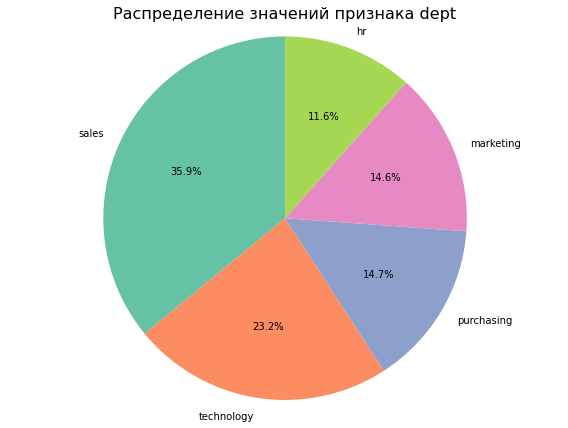

In [77]:
display_categoral_distribution(train_quit,'dept')

Таким образом, большенство объектов работают в отделе sales (36%), остальные отделы распределены следующим образом technology (23.2%), purchasing (14.7%), marketing (14.6%), hr (11.6%) - в целом распределение данных совпдадает с 1 задачей

#### level

junior    1949
middle    1694
senior     357
Name: level, dtype: int64

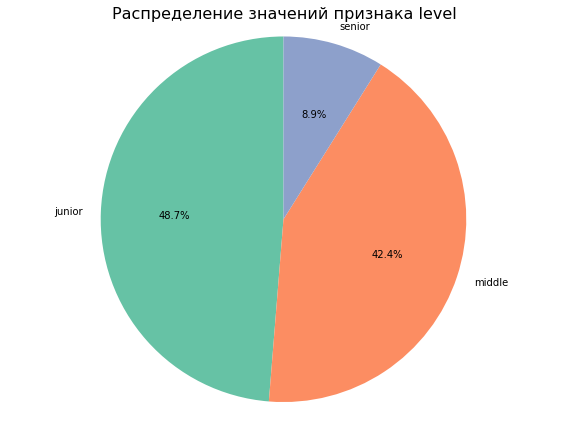

In [78]:
display_categoral_distribution(train_quit,'level')

Таким образом, большенство объектов имеют уровень junior (48.7%) либо уровень middle (42.4%), совсем небольшое количество объектов имеет уровень senior (9%) -  в целом распределение данных совпдадает с 1 задачей

#### workload

medium    2118
low       1208
high       674
Name: workload, dtype: int64

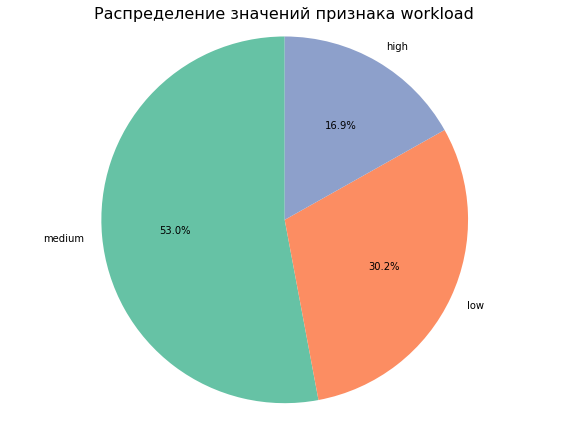

In [79]:
display_categoral_distribution(train_quit,'workload')

Таким образом, почти половина объектов имеют ворклоуд medium (53%) , остальные имеют ворклоуд low (30%) либо же high ( 16.9%) - в целом распределение данных совпдадает с 1 задачей

#### last_year_promo

no     3887
yes     113
Name: last_year_promo, dtype: int64

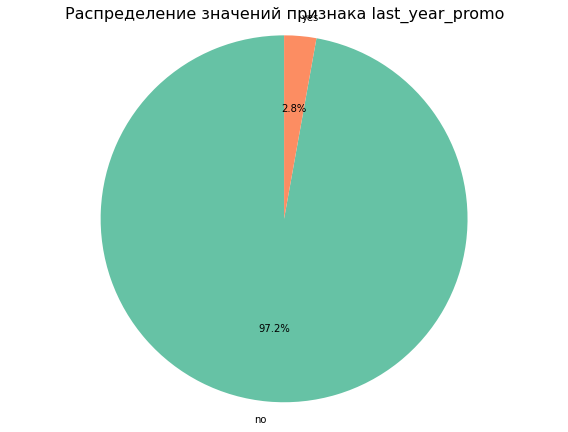

In [80]:
display_categoral_distribution(train_quit,'last_year_promo')

Таким образом, можно заметить, что почти все объекты не имели повышения в прошлом году, и лишь 2.8% имели повышение в прошлом году - в целом распределение данных совпдадает с 1 задачей

#### last_year_violations

no     3455
yes     545
Name: last_year_violations, dtype: int64

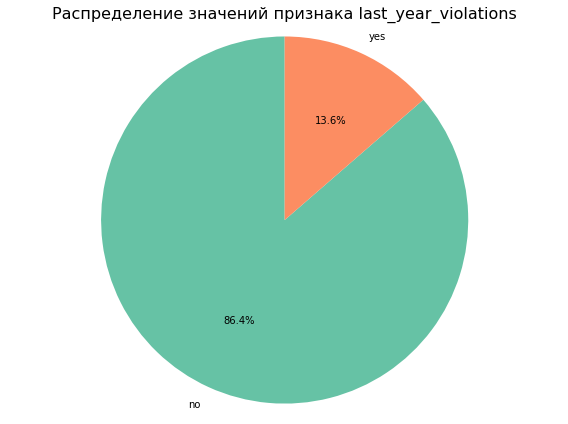

In [81]:
display_categoral_distribution(train_quit,'last_year_violations')

Таким образом, можно заметить, что большенство объектов (86%) не имели нарушений, и 14% имели нарушения в прошлом году - - в целом распределение данных совпдадает с 1 задачей

#### employment_years

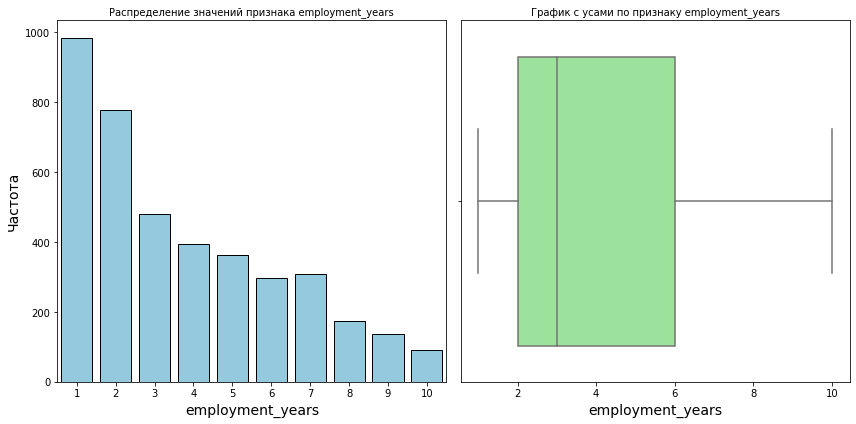

In [82]:
display_discrete_distribution(train_quit,'employment_years')

В компании практически в 2 раза больше сотрудников, которые работают в ней до 3х лет: опытных сотрудников гораздо меньше. Стоит учесть это при переборе параметров для модели в дальнейшем - в целом распределение данных совпдадает с 1 задачей

#### supervisor_evaluation

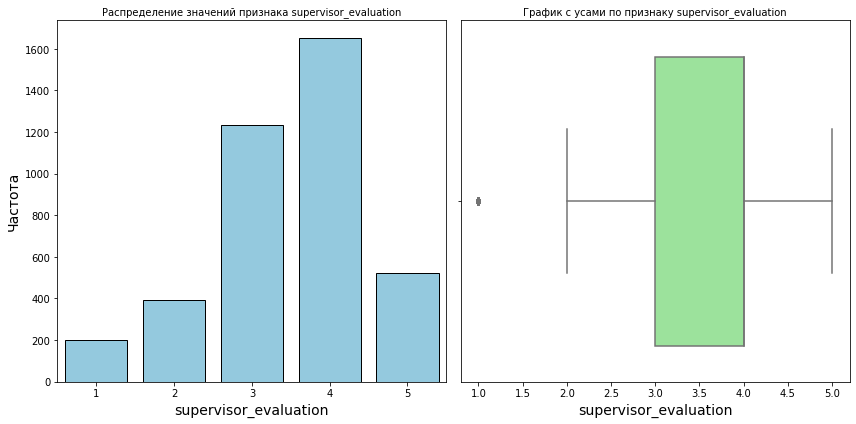

In [83]:
display_discrete_distribution(train_quit,'supervisor_evaluation')

Большенство объектов имеет оценку 4 или 3, так же видно что оценку 1 ставят редко, однако она тоже встречается - в целом распределение данных совпдадает с 1 задачей

#### salary

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

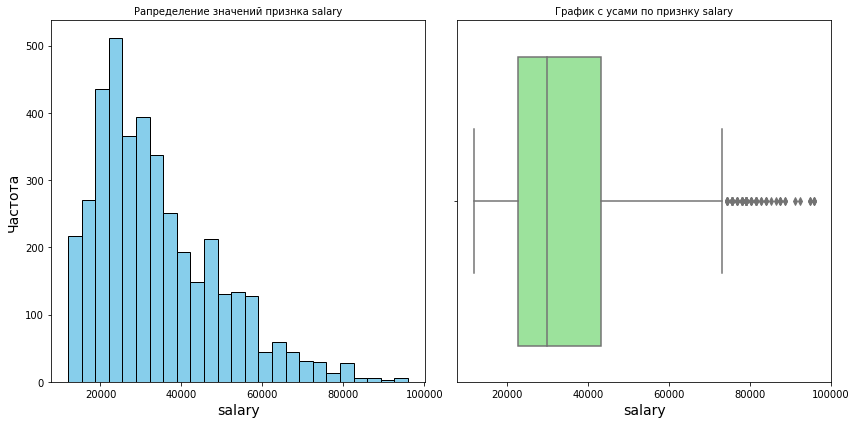

In [84]:
display_quantitative_distribution(train_quit,'salary', 25)

In [85]:
pivot_table = train_quit.pivot_table(
    index='dept',            
    columns='level',         
    values='salary',         
    aggfunc='median',        
    fill_value=0             
)
display(pivot_table)

level,junior,middle,senior
dept,,,
hr,24000,39600,61200
marketing,25200,40800,66000
purchasing,22800,38400,53400
sales,21600,38400,55200
technology,27600,44400,64800


Таким образом, видим, что медианная зарплата растет с ростом уровня во всех отделах - что является обосновонным, а так же "стартовая" медианная зарплата выше в отделе technology, чем в других отделах, так же медианная зарплата в данном отделе выше и на других уровнях. что и показывает выбрросы на общем графике распределения запрлат в компании. По этому не будем удалять данные выбросы

Таким образом, медианная зарплата в компании составляет 30,000, болшенство данных распределено в промежутке от 22,800 до 43,200. Средняя зарпалата больше медианной на почти 34,000. Данные зарплаты распределены нормально со мещением влево. Чем выше уровень объекта, тем выше заработная плата. Самая большая медианная зарплата в отделе technology, самая маленькая - в отедле sales - в целом распределение данных совпдадает с 1 задачей

#### quit

no     2872
yes    1128
Name: quit, dtype: int64

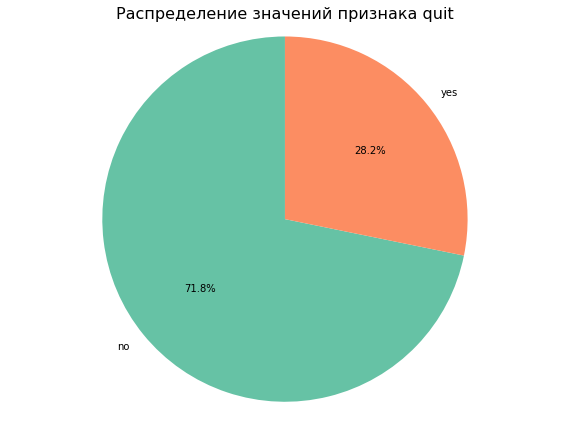

In [86]:
display_categoral_distribution(train_quit,'quit')

Заметим, что существует незначительный дисбаланс целевого признака (3 к 1  - оставщиеся к уволенне)), учетм это при моделировании 

#### Корреляционный анализ

interval columns not set, guessing: ['id', 'employment_years', 'supervisor_evaluation', 'salary']


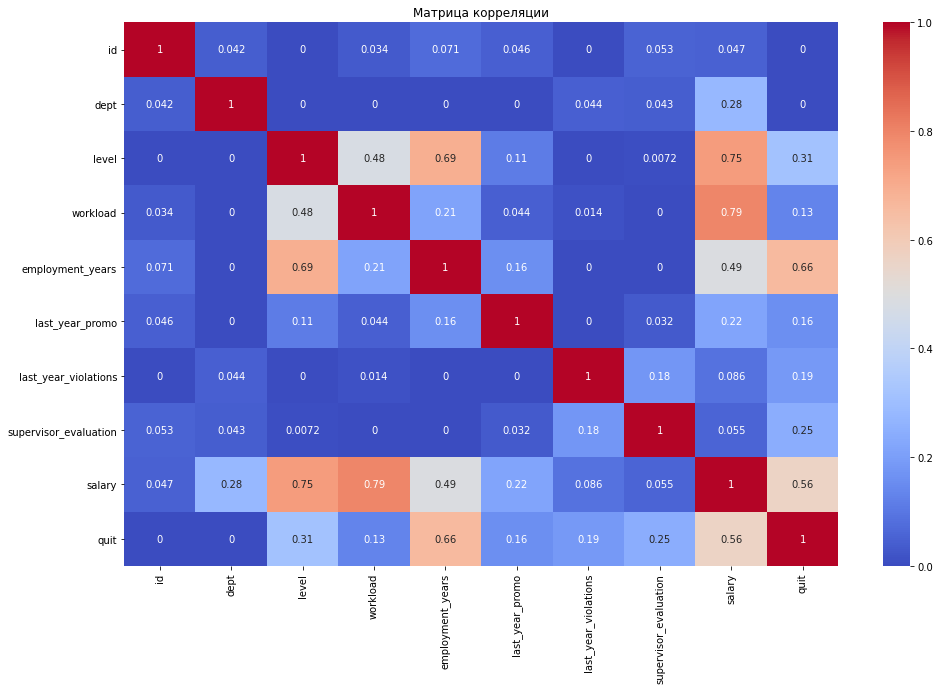

In [87]:
corr_matrix = train_quit.phik_matrix()
plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Заметимя, что целевой (quit) признак имеет следующие зависимости:
1. сильная зависимость с признаком - employment_years (0.66) и salary (0.56)
2. умеренная зависимость с признаком - level (0.31), supervision_evoluation (0.25)
3. слабая зависимость с признаком - last_year_violations(0.19), last_year_promo (0.16), workload(0.13)
5. Не наблюдается связи со следующими признаками - dept, level, workload
Нет связи между целевым признаком, и такми признакми как dept


Так же между входными признаками наблюдаются следующие сильные зависимости: 
1. salary - workload ( 0.79)
2. salary - level ( 0.75) 
3. emplayment_year - level ( 0.69) 
Так как данные коофициенты коорреляуии меньше 0.9 - то мультиколлениарность не наблюдается 

#### Портрет «уволившегося сотрудника»

Всего имеются записи о 1128 уволившихся сотрудниках, что составляет 28.2 % от общего числа сотрудников .
Посмторим на датфрейм уволившихся 

In [88]:
left = train_quit.query('quit == "yes"')
display(left)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes
...,...,...,...,...,...,...,...,...,...,...
3989,150315,purchasing,junior,low,1,no,no,2,15600,yes
3991,778735,technology,junior,low,2,no,no,4,22800,yes
3994,775320,technology,junior,high,1,no,no,4,42000,yes
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes


In [89]:
def display_categoral_distribution_part(df, df_part, column):
    value_counts = df[column].value_counts()
    value_counts_part = df_part[column].value_counts()
    value_counts_part = value_counts_part.reindex(value_counts.index, fill_value=0)

    value_counts_part['proportion'] = value_counts_part / value_counts

    print(value_counts_part['proportion'])
    
    

In [90]:
display_categoral_distribution_part(train_quit, left, 'dept')

sales         0.283032
technology    0.297414
purchasing    0.282313
marketing     0.280069
hr            0.250000
Name: dept, dtype: float64


Заметим, что в среднем доли уволившихся по отделам одинаковые  , но чаще увольняются из отдела technology , меньше всего - hr

In [91]:
display_categoral_distribution_part(train_quit, left, 'level')

junior    0.514623
middle    0.063754
senior    0.047619
Name: level, dtype: float64


Почти половина сотрудников уровня junior увольняются, чем выше уровень - тем ниже доля увольнения, senior  -   0.047619

In [92]:
display_categoral_distribution_part(train_quit, left, 'workload')

medium    0.230406
low       0.429636
high      0.179525
Name: workload, dtype: float64


Почти половина сотрудников с нагрузкой low увольняются, чем выше нагрузка - тем меньше увольнений. с нагрузкой high увольяются 0.179 

In [93]:
display_categoral_distribution_part(train_quit, left, 'last_year_promo')

no     0.289941
yes    0.008850
Name: last_year_promo, dtype: float64


28 процентов тех, кто не получил повышение в прошлом году - увольняются, и лишь 1 процент повышенных увольняется.

In [94]:
display_categoral_distribution_part(train_quit, left, 'last_year_violations')

no     0.260492
yes    0.418349
Name: last_year_violations, dtype: float64


42 процента нарушевыних правила в ПГ увольянются , и лишь 26 процентов не нарушевших увольняются

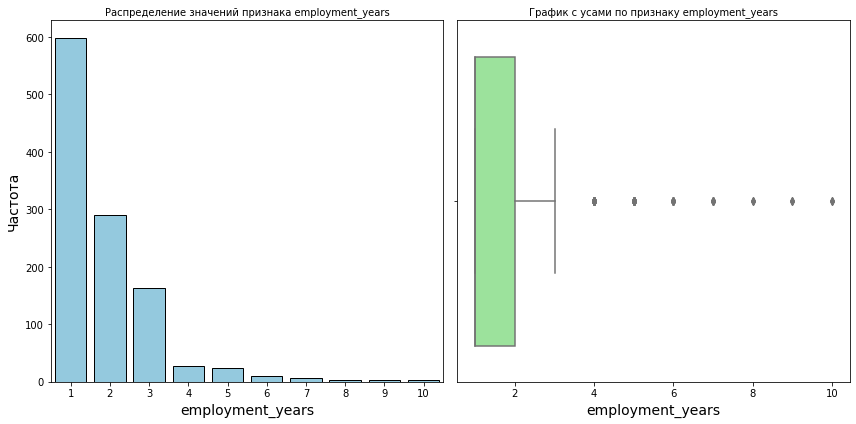

count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64


In [95]:
display_discrete_distribution(left,'employment_years')
print(left['employment_years'].describe())

Среднее значение отработанных лет у отработавшего равно 1.84 лет, юольшенство уволившихся находятс в промежутке от 1 до 2 лет

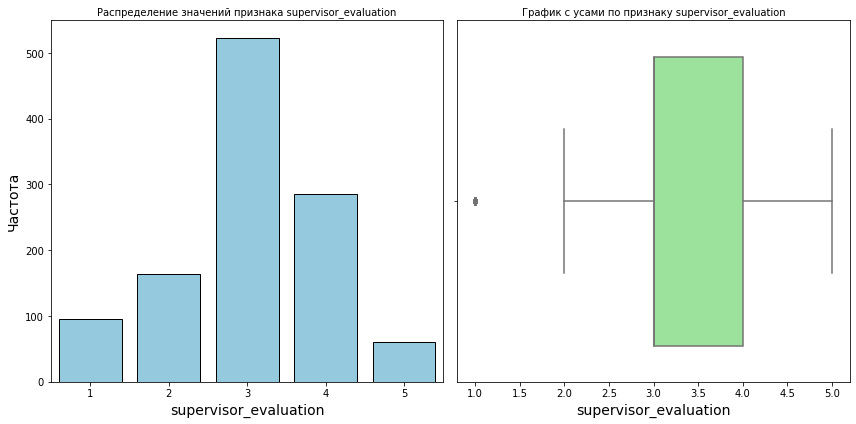

count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [96]:
display_discrete_distribution(left,'supervisor_evaluation')
print(left['supervisor_evaluation'].describe())

Большенство уволившихся получили отметку супервайзера в среднем равную 3, что меньше , чем большенство сотрудников в среднем ( 4) 

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

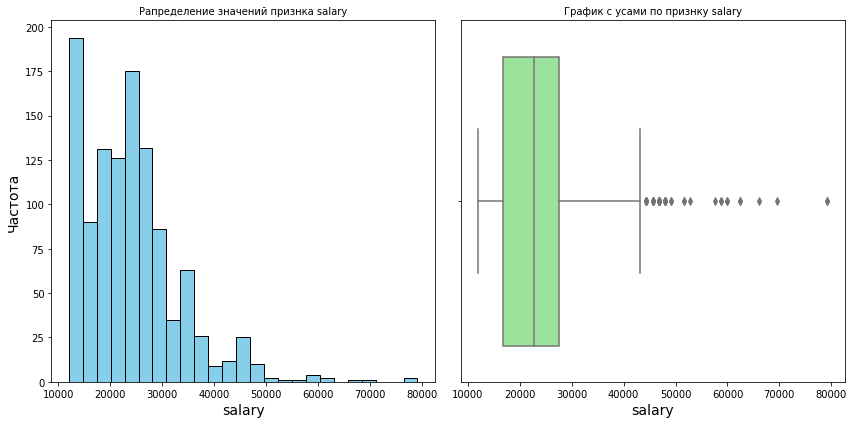

In [97]:
display_quantitative_distribution(left,'salary', 25)

Видно, что средняя зарплата уволившихся меньше чем средняя по компании почти на 10 000 руб, и составляет 23885

##### Вывод

Таким образом, портретом уволивщегося сотруднкиа будет являться : 

1. доли уволившихся по отделам одинаковые  , но чаще увольняются из отдела technology , меньше всего - hr
2. почти половина сотрудников уровня junior увольняются, чем выше уровень - тем ниже доля увольнения, senior очень редко увольняются
3. почти половина сотрудников с нагрузкой low увольняются, чем выше нагрузка - тем меньше увольнений. с нагрузкой high увольяются 0.179 
4. 28 процентов тех, кто не получил повышение в прошлом году - увольняются, и лишь 1 процент повышенных увольняется.
5. 42 процента нарушевыних правила в ПГ увольянются , и лишь 26 процентов не нарушевших увольняются
6. среднее значение отработанных лет у отработавшего равно 1.84 лет, юольшенство уволившихся находятс в промежутке от 1 до 2 лет
7. большенство уволившихся получили отметку супервайзера в среднем равную 3, что меньше , чем большенство сотрудников в среднем ( 4)
8. средняя зарплата уволившихся меньше чем средняя по компании почти на 10 000 руб, и составляет 23885

#### JSR и QUIT

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. 
Проверим это утверждение: визуализируем и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

In [98]:
jsr_quit_1 = y_test_1.to_frame()
jsr_quit_2 = y_test_2
jsr_quit = jsr_quit_1.merge(jsr_quit_2, on='id', how='left')
display(jsr_quit.head())

,id,job_satisfaction_rate,quit
0,485046,0.79,no
1,686555,0.72,no
2,467458,0.64,no
3,418655,0.60,no
4,789145,0.75,no


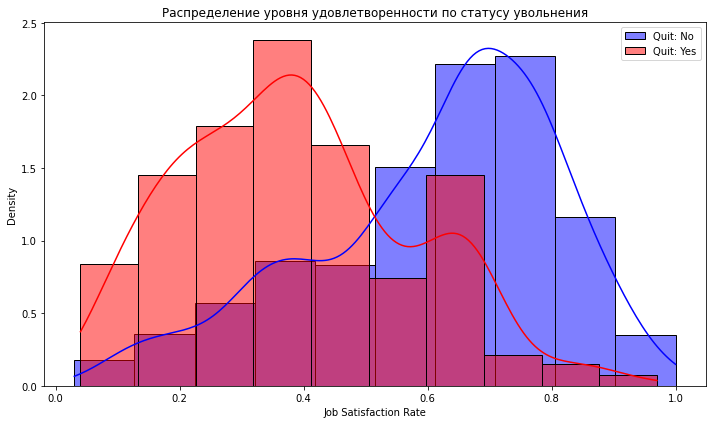

In [99]:
quit_no = jsr_quit[jsr_quit['quit'] == 'no']
quit_yes = jsr_quit[jsr_quit['quit'] == 'yes']

plt.figure(figsize=(10, 6))

sns.histplot(quit_no['job_satisfaction_rate'], kde=True, color='blue', label='Quit: No', stat='density', bins=10)
sns.histplot(quit_yes['job_satisfaction_rate'], kde=True, color='red', label='Quit: Yes', stat='density', bins=10)

plt.title('Распределение уровня удовлетворенности по статусу увольнения')
plt.xlabel('Job Satisfaction Rate')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

In [100]:
print(jsr_quit[jsr_quit['quit'] == 'no']['job_satisfaction_rate'].describe())

count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [101]:
print(jsr_quit[jsr_quit['quit'] == 'yes']['job_satisfaction_rate'].describe())

count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64


Таким образом, заметим, что JSR уволившихся сотрудников в среднем составляет 0.38, в то время как JSR неуволивщихся сотрудников составляет 0.61. На графике видно, что уволевщиеся сотрудники имеют распределение JSR слева, а оставшиеся - справа.
В виду этого есть смысл включить JSR (предсказанынй линейной регрессией) как дополнительный признак для обучения модели и решения второй задачи

#### Вывод

Мы провели исследовательский анализ данных и заметили, что распределение входных признаков второй задачи совпадает с распределением входных признаков первой задачи : 
1. dept - большенство объектов работают в отделе sales (36%), остальные отделы распределены следующим образом technology (23.2%), purchasing (14.7%), marketing (14.6%), hr (11.6%) 
2. level -большенство объектов имеют уровень junior (48.7%) либо уровень middle (42.4%), совсем небольшое количество объектов имеет уровень senior (9%) 
3. workload - половина объектов имеют ворклоуд medium (53%) , остальные имеют ворклоуд low (30%) либо же high ( 16.9%)
4. last_year_promo - очти все объекты не имели повышения в прошлом году, и лишь 2.8% имели повышение в прошлом году
5. last_year_violations - большенство объектов (86%) не имели нарушений, и 14% имели нарушения в прошлом году
6. employmant_years - в компании практически в 2 раза больше сотрудников, которые работают в ней до 3х лет: опытных сотрудников гораздо меньше. Стоит учесть это при переборе параметров для модели в дальнейшем
7. supervisor_evaluation - большенство объектов имеет оценку 4 или 3, так же видно что оценку 1 ставят редко, однако она тоже встречается
8. salary - медианная зарплата в компании составляет 30,000, болшенство данных распределено в промежутке от 22,800 до 43,200. Средняя зарпалата больше медианной на почти 34,000. Данные зарплаты распределены нормально со мещением влево. Чем выше уровень объекта, тем выше заработная плата. Самая большая медианная зарплата в отделе technology, самая маленькая - в отедле sales
9. quit -  существует незначительный дисбаланс целевого признака (3 к 1 - оставщиеся к уволенне)), учетм это при моделировании


Так же мы провели корреляционный анализ и заметили, что целевой признак имеет следующие зависимости:
1. сильная зависимость с признаком - employment_years (0.66) и salary (0.56)
2. умеренная зависимость с признаком - level (0.31), supervision_evoluation (0.25)
3. слабая зависимость с признаком - last_year_violations(0.19), last_year_promo (0.16), workload(0.13)
5. Не наблюдается связи со следующими признаками - dept, level, workload
Нет связи между целевым признаком, и такми признакми как dept


Так же между входными признаками наблюдаются следующие сильные зависимости: 
1. salary - workload ( 0.79)
2. salary - level ( 0.75) 
3. emplayment_year - level ( 0.69) 
Так как данные коофициенты коорреляуии меньше 0.9 - то мультиколлениарность не наблюдается 

Мы составили партрет уволившегося сотрудника : 

1. доли уволившихся по отделам одинаковые  , но чаще увольняются из отдела technology , меньше всего - hr
2. почти половина сотрудников уровня junior увольняются, чем выше уровень - тем ниже доля увольнения, senior очень редко увольняются
3. почти половина сотрудников с нагрузкой low увольняются, чем выше нагрузка - тем меньше увольнений. с нагрузкой high увольяются 0.179 
4. 28 процентов тех, кто не получил повышение в прошлом году - увольняются, и лишь 1 процент повышенных увольняется.
5. 42 процента нарушевыних правила в ПГ увольянются , и лишь 26 процентов не нарушевших увольняются
6. среднее значение отработанных лет у отработавшего равно 1.84 лет, юольшенство уволившихся находятс в промежутке от 1 до 2 лет
7. большенство уволившихся получили отметку супервайзера в среднем равную 3, что меньше , чем большенство сотрудников в среднем ( 4)
8. средняя зарплата уволившихся меньше чем средняя по компании почти на 10 000 руб, и составляет 23885

Так же мы посомтрели на распределение JSR у уволивщихся сотрудников и оставщихся, и заметили, что: 

JSR уволившихся сотрудников в среднем составляет 0.38, в то время как JSR неуволивщихся сотрудников составляет 0.61. На графике видно, что уволевщиеся сотрудники имеют распределение JSR слева, а оставшиеся - справа.
В виду этого есть смысл включить JSR (предсказанынй линейной регрессией) как дополнительный признак для обучения модели и решения второй задачи


### Добавление нового входного признака

Добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи (линейной регрессией), к входным признакам второй задачи

In [102]:
train_quit = train_quit.set_index('id')

In [103]:
display(train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


In [104]:
jsr_train = randomized_search.best_estimator_.predict(train_quit)
display(jsr_train)

array([0.648     , 0.84242424, 0.35      , ..., 0.52      , 0.50375   ,
       0.5125    ])

In [105]:
train_quit['job_satisfaction_rate'] = jsr_train
display(train_quit)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.648000
814010,sales,junior,medium,2,no,no,4,27600,no,0.842424
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.350000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.358571
910140,marketing,junior,medium,2,no,no,5,25200,no,0.797857
...,...,...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400,no,0.512500
672059,sales,middle,high,9,no,no,4,52800,no,0.835000
536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.520000


In [106]:
X_test_2 = X_test_2.set_index('id')

In [107]:
jsr_test = randomized_search.best_estimator_.predict(X_test_2)
display(jsr_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([0.83574468, 0.67041667, 0.654     , ..., 0.24      , 0.55      ,
       0.604     ])

In [108]:
X_test_2['job_satisfaction_rate'] = jsr_test

In [109]:
display(X_test_2.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.835745
686555,hr,junior,medium,1,no,no,4,30000,0.670417
467458,sales,middle,low,5,no,no,4,19200,0.654000
418655,sales,middle,low,6,no,no,4,19200,0.655000
789145,hr,middle,medium,5,no,no,5,40800,0.816098


### Подготовка данных

#### Закодируем значения целевого признака 

In [110]:
display(train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.648000
814010,sales,junior,medium,2,no,no,4,27600,no,0.842424
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.350000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.358571
910140,marketing,junior,medium,2,no,no,5,25200,no,0.797857


In [111]:
display(y_test_2.head())

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [112]:
le = LabelEncoder()
le.fit(["no", "yes"])
train_quit['quit'] = le.transform(train_quit['quit'])
y_test_2['quit'] = le.transform(y_test_2['quit'])

In [113]:
display(train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0,0.648000
814010,sales,junior,medium,2,no,no,4,27600,0,0.842424
155091,purchasing,middle,medium,5,no,no,1,37200,0,0.350000
257132,sales,junior,medium,2,no,yes,3,24000,1,0.358571
910140,marketing,junior,medium,2,no,no,5,25200,0,0.797857


In [114]:
display(y_test_2.head())

,id,quit
0,999029,1
1,372846,0
2,726767,0
3,490105,0
4,416898,1


#### Дубликаты входных признаков

In [115]:
display(train_quit)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0,0.648000
814010,sales,junior,medium,2,no,no,4,27600,0,0.842424
155091,purchasing,middle,medium,5,no,no,1,37200,0,0.350000
257132,sales,junior,medium,2,no,yes,3,24000,1,0.358571
910140,marketing,junior,medium,2,no,no,5,25200,0,0.797857
...,...,...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400,0,0.512500
672059,sales,middle,high,9,no,no,4,52800,0,0.835000
536432,purchasing,junior,low,2,no,yes,4,12000,1,0.520000


In [116]:
train_2 = train_quit

Посмотрим, есть ли дубликаты признаков без учета id

In [117]:
print(train_2.duplicated().sum())

1413


Оставим данные дубликаты

In [118]:
display(train_2.head())
print(train_2.shape)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0,0.648000
814010,sales,junior,medium,2,no,no,4,27600,0,0.842424
155091,purchasing,middle,medium,5,no,no,1,37200,0,0.350000
257132,sales,junior,medium,2,no,yes,3,24000,1,0.358571
910140,marketing,junior,medium,2,no,no,5,25200,0,0.797857


(4000, 10)


Таким образом мы удалили дубликаты входных признаков и целевого, и осталось в итоге 2587 обхектов для обучения 

#### Создадим датафреймы для обучения модели

In [119]:
X_train_2 = train_2.drop('quit', axis=1)
display(X_train_2.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.648000
814010,sales,junior,medium,2,no,no,4,27600,0.842424
155091,purchasing,middle,medium,5,no,no,1,37200,0.350000
257132,sales,junior,medium,2,no,yes,3,24000,0.358571
910140,marketing,junior,medium,2,no,no,5,25200,0.797857


In [120]:
y_train_2 = train_2['quit']
display(y_train_2.head())

id
723290    0
814010    0
155091    0
257132    1
910140    0
Name: quit, dtype: int64

In [121]:
y_test_2 = y_test_2.set_index('id')

In [122]:
display(X_test_2.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.835745
686555,hr,junior,medium,1,no,no,4,30000,0.670417
467458,sales,middle,low,5,no,no,4,19200,0.654000
418655,sales,middle,low,6,no,no,4,19200,0.655000
789145,hr,middle,medium,5,no,no,5,40800,0.816098


In [123]:
display(y_test_2.head())

,quit
id,
999029,1
372846,0
726767,0
490105,0
416898,1


In [124]:
full_test_2 =X_test_2.merge(y_test_2, right_index=True, left_index=True)
display(full_test_2)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.835745,0
686555,hr,junior,medium,1,no,no,4,30000,0.670417,0
467458,sales,middle,low,5,no,no,4,19200,0.654000,0
418655,sales,middle,low,6,no,no,4,19200,0.655000,0
789145,hr,middle,medium,5,no,no,5,40800,0.816098,0
...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.514286,1
109582,technology,middle,low,3,no,no,2,21600,0.220000,1
305653,technology,junior,low,1,no,no,3,14400,0.240000,1


In [125]:
print(full_test_2['quit'].isna().sum())

0


In [126]:
y_test_2 = full_test_2['quit']
X_test_2 = full_test_2.drop('quit', axis=1)
display(y_test_2.head())
display(X_test_2.head())

id
485046    0
686555    0
467458    0
418655    0
789145    0
Name: quit, dtype: int64

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.835745
686555,hr,junior,medium,1,no,no,4,30000,0.670417
467458,sales,middle,low,5,no,no,4,19200,0.654000
418655,sales,middle,low,6,no,no,4,19200,0.655000
789145,hr,middle,medium,5,no,no,5,40800,0.816098


Таким образом, мы создали обучающие датафреймы X_test_2, y_test_2 , а так же для тестирования моделей, созданные на основе полученных файлов, y_test_2, X_test_2

#### Создание пайплайнов

Обновим данные для пайплайна, созданного в  1 задаче

In [127]:
num_columns.append('job_satisfaction_rate')

In [128]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

### Обучение модели

#### Подбор гиперпараметров

In [129]:
param_grid_test_2 = [
    {
        'models': [LogisticRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {    
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(6, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [KNeighborsClassifier(n_jobs=-1, weights='distance')],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
]

randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_distributions=param_grid_test_2, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=5,
    n_iter=20
)


randomized_search_2.fit(X_train_2, y_train_2) 



current_best_model_2 = randomized_search_2.best_estimator_['models']
probabilities = randomized_search_2.best_estimator_.predict_proba(X_test_2)
probabilities_one = probabilities[:, 1]
current_train_score_2 = randomized_search_2.best_score_
current_test_score_2 = roc_auc_score(y_test_2, probabilities_one)

print(current_best_model_2)
print('ROC-AUC лучшей модели на кросс-валидации по обучающей выборке:', current_train_score_2)
print(f'ROC-AUC на тестовой выборке: {current_test_score_2}')
print()

DecisionTreeClassifier(max_depth=6, max_features=9, random_state=42)
ROC-AUC лучшей модели на кросс-валидации по обучающей выборке: 0.9275888423925517
ROC-AUC на тестовой выборке: 0.9200485489638277



/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучшая модель по итогу перебора - DecisionTreeClassifier(max_depth=6, max_features=9, random_state=42)
ROC-AUC на тестовой выборке - 0.9200485489638277  в целом такой же и на тренировочной, 
Данная метрика показывает хороший резульатат, удовлетворяющий успеху ! 

In [131]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(randomized_search_2.cv_results_)[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score').head(10)

,rank_test_score,mean_test_score,params
19,1,0.927589,"{'preprocessor__num': StandardScaler(), 'models__max_features': 9, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
11,2,0.924816,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
3,3,0.921383,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 8, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
0,3,0.921383,"{'preprocessor__num': StandardScaler(), 'models__max_features': 8, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
1,5,0.918739,"{'preprocessor__num': StandardScaler(), 'models': LogisticRegression()}"
5,6,0.918251,"{'preprocessor__num': StandardScaler(), 'models__max_features': 7, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
10,7,0.917000,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 9, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
15,8,0.915929,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 7, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
13,9,0.913466,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 6, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
18,10,0.913351,"{'preprocessor__num': StandardScaler(), 'models__max_features': 9, 'models__max_depth': 8, 'models': DecisionTreeClassifier(random_state=42)}"


#### Анализ важности признаков

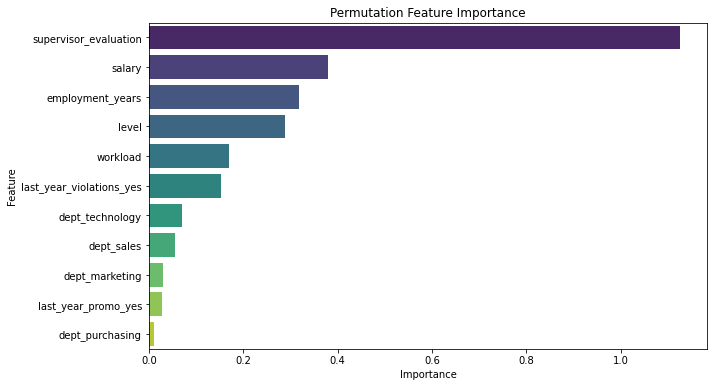

In [132]:
best_model_2 = randomized_search_2.best_estimator_
X_train_transformed_2 = best_model_2.named_steps['preprocessor'].transform(X_train_2)

perm_importance_2 = permutation_importance(best_model_2.named_steps['models'], X_train_transformed_2, y_train_2, n_repeats=10, random_state=42)

importance_values_2 = perm_importance_2.importances_mean
importance_std_2 = perm_importance_2.importances_std

feature_names_2 = []

if hasattr(best_model_2.named_steps['preprocessor'].transformers_[0][1], 'get_feature_names_out'):
    ohe_feature_names_2 = best_model_2.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(ohe_columns)
    feature_names_2.extend(ohe_feature_names_2)

if hasattr(best_model_2.named_steps['preprocessor'].transformers_[1][1], 'get_feature_names_out'):
    ord_feature_names_2 = ord_columns  
    feature_names_2.extend(ord_feature_names_2)

if hasattr(best_model_2.named_steps['preprocessor'].transformers_[2][1], 'get_feature_names_out'):
    num_feature_names_2 = best_model_2.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out()
    feature_names_2.extend(num_feature_names_2)

passthrough_columns_2 = best_model_2.named_steps['preprocessor'].transformers_[3][2] if len(best_model_2.named_steps['preprocessor'].transformers_) > 3 else []
feature_names_2.extend(passthrough_columns_2)

importance_df_2 = pd.DataFrame({
    'Feature': feature_names_2,
    'Importance': importance_values_2,
    'Std': importance_std_2
})

importance_df_2 = importance_df_2.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Permutation Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
PermutationExplainer explainer: 2001it [00:40, 41.79it/s]                          


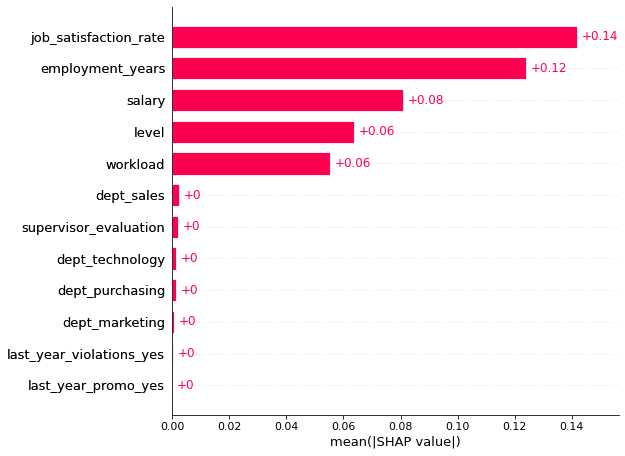

In [133]:
best_model_2 = randomized_search_2.best_estimator_
X_test_transformed_2 = best_model_2.named_steps['preprocessor'].transform(X_test_2)
explainer_2 = shap.PermutationExplainer(randomized_search_2.best_estimator_.named_steps['models'].predict_proba, X_test_transformed_2)
explainer_2.feature_names = feature_names_2
shap_values_2 = explainer_2(X_test_transformed_2)
shap.plots.bar(shap_values_2[:,:,1], max_display=16)

Заметим, что самые важные признаки для модели являются: 
1. JSR
2. employment_years
3. salary
4. level
5. workload

Все остальные признаки не имеют влияния на модели 
В виду того, что успех достигнут, не будем удалять признаки

### Вывод

Для решения второй задачи мы получили исходные данные для решения второй задачи, для тестовой выборки входных признаков использован датафрейм из первой задачи ( в виду этого пропустим предобработку данных для этого датафрейма) 
Мы выявили, что : 
1. Названия столбцов не нужно менять
2. Все названия столбцов в трех таблицах одинаковы
3. Типы данных во всех датафреймах всех признаков совпадают с описанием.
4. Пропусков данных не обнарудено
Провели предобработку данных и выявили, что 
train_quit:

1. исправили орфографическую ошибку sinior на senior в столбце level

X_test_2:

С датасетом все в порядке

y_test_2:

С датасетом все в порядке

Мы провели исследовательский анализ данных, и выявили, что: 
распределение входных признаков второй задачи совпадает с распределением входных признаков первой задачи : 
1. dept - большенство объектов работают в отделе sales (36%), остальные отделы распределены следующим образом technology (23.2%), purchasing (14.7%), marketing (14.6%), hr (11.6%) 
2. level -большенство объектов имеют уровень junior (48.7%) либо уровень middle (42.4%), совсем небольшое количество объектов имеет уровень senior (9%) 
3. workload - половина объектов имеют ворклоуд medium (53%) , остальные имеют ворклоуд low (30%) либо же high ( 16.9%)
4. last_year_promo - очти все объекты не имели повышения в прошлом году, и лишь 2.8% имели повышение в прошлом году
5. last_year_violations - большенство объектов (86%) не имели нарушений, и 14% имели нарушения в прошлом году
6. employmant_years - в компании практически в 2 раза больше сотрудников, которые работают в ней до 3х лет: опытных сотрудников гораздо меньше. Стоит учесть это при переборе параметров для модели в дальнейшем
7. supervisor_evaluation - большенство объектов имеет оценку 4 или 3, так же видно что оценку 1 ставят редко, однако она тоже встречается
8. salary - медианная зарплата в компании составляет 30,000, болшенство данных распределено в промежутке от 22,800 до 43,200. Средняя зарпалата больше медианной на почти 34,000. Данные зарплаты распределены нормально со мещением влево. Чем выше уровень объекта, тем выше заработная плата. Самая большая медианная зарплата в отделе technology, самая маленькая - в отедле sales
9. quit -  существует незначительный дисбаланс целевого признака (3 к 1 - оставщиеся к уволенне)), учетм это при моделировании


Так же мы провели корреляционный анализ и заметили, что целевой признак имеет следующие зависимости:
1. сильная зависимость с признаком - employment_years (0.66) и salary (0.56)
2. умеренная зависимость с признаком - level (0.31), supervision_evoluation (0.25)
3. слабая зависимость с признаком - last_year_violations(0.19), last_year_promo (0.16), workload(0.13)
5. Не наблюдается связи со следующими признаками - dept, level, workload
Нет связи между целевым признаком, и такми признакми как dept


Так же между входными признаками наблюдаются следующие сильные зависимости: 
1. salary - workload ( 0.79)
2. salary - level ( 0.75) 
3. emplayment_year - level ( 0.69) 
Так как данные коофициенты коорреляуии меньше 0.9 - то мультиколлениарность не наблюдается 

Мы составили партрет уволившегося сотрудника : 

1. доли уволившихся по отделам одинаковые  , но чаще увольняются из отдела technology , меньше всего - hr
2. почти половина сотрудников уровня junior увольняются, чем выше уровень - тем ниже доля увольнения, senior очень редко увольняются
3. почти половина сотрудников с нагрузкой low увольняются, чем выше нагрузка - тем меньше увольнений. с нагрузкой high увольяются 0.179 
4. 28 процентов тех, кто не получил повышение в прошлом году - увольняются, и лишь 1 процент повышенных увольняется.
5. 42 процента нарушевыних правила в ПГ увольянются , и лишь 26 процентов не нарушевших увольняются
6. среднее значение отработанных лет у отработавшего равно 1.84 лет, юольшенство уволившихся находятс в промежутке от 1 до 2 лет
7. большенство уволившихся получили отметку супервайзера в среднем равную 3, что меньше , чем большенство сотрудников в среднем ( 4)
8. средняя зарплата уволившихся меньше чем средняя по компании почти на 10 000 руб, и составляет 23885

Так же мы посомтрели на распределение JSR у уволивщихся сотрудников и оставщихся, и заметили, что: 

JSR уволившихся сотрудников в среднем составляет 0.38, в то время как JSR неуволивщихся сотрудников составляет 0.61. На графике видно, что уволевщиеся сотрудники имеют распределение JSR слева, а оставшиеся - справа.
В виду этого есть смысл включить JSR (предсказанынй линейной регрессией) как дополнительный признак для обучения модели и решения второй задачи


Мы провели подготовку данных, и выявили, что: 
обучающая выборка была равна 4000 объектов и 2204 обхектов с одинаковыми входными признаками, мы решили не удалять данные дубликаты , так как маловеротяно , что это ошибка в данных, а реальные объекты 


Мы обучили три модели Логисчтическая регрессия, деревья решений, и модель Knn и определили, что : 
Лучшая модель по итогу перебора - DecisionTreeClassifier(max_depth=6, max_features=9, random_state=42)
ROC-AUC на тестовой выборке - 0.9200485489638277  в целом такой же и на тренировочной, 
Данная метрика показывает хороший резульатат, удовлетворяющий успеху ! 

Мы проанализировали важность признаков и выявили, что: 
самые важные признаки для модели являются: 
1. JSR
2. employment_years
3. salary
4. level
5. workload

Все остальные признаки не имеют влияния на модели 
В виду того, что успех достигнут, не будем удалять признаки

## Вывод

В ходе работы над проектом были решены две ключевые задачи: регрессии и классификации. Были созданы , протестированы и выбраны 2 лучшие модели, которые успешно прошли порог оценки качества

ПРЕДСКАЗАНИЕ УРОВНЯ УДОВЛЕТВОРЕННОСТИ СОТРУДНИКА

Мы загрузили необходимые для выполнения исследования билиотеки, а так же получили исходные данные.
Мы выявили, что : 
1. Названия столбцов не нужно менять
2. Все названия столбцов в трех таблицах одинаковы
3. Типы данных во всех датафреймах всех признаков совпадают с описанием.
4. Были выявлено незначительное количество пропусков в таких датафреймах как train_jsr, test_features_jsr в таких столбцах как dept , level ( категориальные данные) - данные пропуски заполним в будущем при помощи пайплайна, нет необходимости удалять их 

Мы провели предобработку данных и выявили, что 
train_jsr:

1. исправили орфографическую ошибку sinior на senior в столбце level
2. заметили, что есть пропуски , которые заменим в пайплайне с обучением модели
test_features_jsr:

1. исправили орфографическую ошибку sinior на senior в столбце level
2. заметили, что есть пропуски , которые заменим в пайплайне с обучением модели
3.  заметили, что есть пробелы (" "), которые заменим в пайплайне с обучением модели

test_target_jsr:

С датасетом все в порядке

Мы провели иследовательский анализ данных, и выявили, что: 

Мы провели исследовательский анализ данных и заметили, что: 
1. dept - большенство объектов работают в отделе sales (38%), остальные отделы распределены следующим образом technology (21.6%), purchasing (15.3%), marketing (13.8%), hr (11.4%)
2. level - большенство объектов имеют уровень junior (47.5%) либо уровень middle (43.6%), совсем небольшое количество объектов имеет уровень senior (9%)
3. workload - половина объектов имеют ворклоуд medium (51.6%) , остальные имеют ворклоуд low (30%) либо же high ( 18.4%)
4. last_year_promo - почти все объекты не имели повышения в прошлом году, и лишь 3% имели повышение в прошлом году
5. last_year_violations - большенство объектов (86%) не имели нарушений, и  14% имели нарушения в прошлом году
6. employmant_years - в компании практически в 2 раза больше сотрудников, которые работают в ней до 3х лет: опытных сотрудников гораздо меньше. Стоит учесть это при переборе параметров для модели в дальнейшем
7. supervisor_evaluation - большенство объектов имеет оценку 4 или 3, так же видно что оценку 1 ставят редко, однако она тоже встречается
8. salary - медианная зарплата в компании составляет 30,000, болшенство данных распределено в промежутке от 22,800 до 43,200. Средняя зарпалата больше медианной на почти 34,000. Данные зарплаты распределены нормально со мещением влево. Чем выше уровень объекта, тем выше заработная плата. Самая большая медианная зарплата в отделе technology, самая маленькая - в отедле sales
9. job_satisfaction_rate - целевой признака распределены нормально,  с медианным значеннием равным 0.56 и средним 0.53, большенство данных распределено в промежутке от 0.36 до 0.71.

Так же мы провели корреляционный анализ и заметили, что целевой признак имеет следующие зависимости:
1. очень сильная зависимость с признаком - supervisor_evaluation (0.76)
2. сильная зависимость с признаком  - last_year_violations (0.56)
3. - умеренная зависимость с признаком - employment_years (0.33)
4. слабая зависимость с признаком - last_year_promo(0.19), salary (0.17)
5. Не наблюдается связи со следующими признаками - dept, level, workload

Так же между входными признаками наблюдаются следующие сильные зависимости: 
1. salary - workload ( 0.79)
2. salary - level ( 0.72) 
3. emplayment_year - level ( 0.68) 
Так как данные коофициенты коорреляуии меньше 0.9 - то мультиколлениарность не наблюдается 

Так же мы провели исследовательский анализ данных признаков тестовых данных и установили, что данные в тестовых данных распределены в целом также, как и данные признаков в тренировочной выборке


Мы провели подготовку данных и обучение моделей, и выявили, что: 
Мы создали свою метрику для оценки моделей — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). Успехом будет считаться значение метрики SMAPE меньше 15 на тестовой выборке.


Будем рассматривать такие модели, как линейная регрессия, дерево решений

Лучшая модель по итогу перебора -DecisionTreeRegressor(max_depth=12, max_features=8, random_state=42)
SMAPE на тестовой выборке - 14.212648779981658- что удовлетворяет успеху

Заметим, что самыми важными признаками, которые больше всего влияют на определение моделью JSR являются: 
1. supervisor_evalustion
2. salary
3. employment_years
4. level
5. workload
6. last_year_viloations_yes
7. dept

ПРЕДСКАЗАНИЕ УВОЛЬНЕНИЯ СОТРУДНИКА ИЗ КОМПАНИИ

Для решения второй задачи мы получили исходные данные для решения второй задачи, для тестовой выборки входных признаков использован датафрейм из первой задачи ( в виду этого пропустим предобработку данных для этого датафрейма) 
Мы выявили, что : 
1. Названия столбцов не нужно менять
2. Все названия столбцов в трех таблицах одинаковы
3. Типы данных во всех датафреймах всех признаков совпадают с описанием.
4. Пропусков данных не обнарудено
Провели предобработку данных и выявили, что 
train_quit:

1. исправили орфографическую ошибку sinior на senior в столбце level

X_test_2:

С датасетом все в порядке

y_test_2:

С датасетом все в порядке

Мы провели исследовательский анализ данных, и выявили, что: 
распределение входных признаков второй задачи совпадает с распределением входных признаков первой задачи : 
1. dept - большенство объектов работают в отделе sales (36%), остальные отделы распределены следующим образом technology (23.2%), purchasing (14.7%), marketing (14.6%), hr (11.6%) 
2. level -большенство объектов имеют уровень junior (48.7%) либо уровень middle (42.4%), совсем небольшое количество объектов имеет уровень senior (9%) 
3. workload - половина объектов имеют ворклоуд medium (53%) , остальные имеют ворклоуд low (30%) либо же high ( 16.9%)
4. last_year_promo - очти все объекты не имели повышения в прошлом году, и лишь 2.8% имели повышение в прошлом году
5. last_year_violations - большенство объектов (86%) не имели нарушений, и 14% имели нарушения в прошлом году
6. employmant_years - в компании практически в 2 раза больше сотрудников, которые работают в ней до 3х лет: опытных сотрудников гораздо меньше. Стоит учесть это при переборе параметров для модели в дальнейшем
7. supervisor_evaluation - большенство объектов имеет оценку 4 или 3, так же видно что оценку 1 ставят редко, однако она тоже встречается
8. salary - медианная зарплата в компании составляет 30,000, болшенство данных распределено в промежутке от 22,800 до 43,200. Средняя зарпалата больше медианной на почти 34,000. Данные зарплаты распределены нормально со мещением влево. Чем выше уровень объекта, тем выше заработная плата. Самая большая медианная зарплата в отделе technology, самая маленькая - в отедле sales
9. quit -  существует незначительный дисбаланс целевого признака (3 к 1 - оставщиеся к уволенне)), учетм это при моделировании


Так же мы провели корреляционный анализ и заметили, что целевой признак имеет следующие зависимости:
1. сильная зависимость с признаком - employment_years (0.66) и salary (0.56)
2. умеренная зависимость с признаком - level (0.31), supervision_evoluation (0.25)
3. слабая зависимость с признаком - last_year_violations(0.19), last_year_promo (0.16), workload(0.13)
5. Не наблюдается связи со следующими признаками - dept, level, workload
Нет связи между целевым признаком, и такми признакми как dept


Так же между входными признаками наблюдаются следующие сильные зависимости: 
1. salary - workload ( 0.79)
2. salary - level ( 0.75) 
3. emplayment_year - level ( 0.69) 
Так как данные коофициенты коорреляуии меньше 0.9 - то мультиколлениарность не наблюдается 

Мы составили партрет уволившегося сотрудника : 

1. доли уволившихся по отделам одинаковые  , но чаще увольняются из отдела technology , меньше всего - hr
2. почти половина сотрудников уровня junior увольняются, чем выше уровень - тем ниже доля увольнения, senior очень редко увольняются
3. почти половина сотрудников с нагрузкой low увольняются, чем выше нагрузка - тем меньше увольнений. с нагрузкой high увольяются 0.179 
4. 28 процентов тех, кто не получил повышение в прошлом году - увольняются, и лишь 1 процент повышенных увольняется.
5. 42 процента нарушевыних правила в ПГ увольянются , и лишь 26 процентов не нарушевших увольняются
6. среднее значение отработанных лет у отработавшего равно 1.84 лет, юольшенство уволившихся находятс в промежутке от 1 до 2 лет
7. большенство уволившихся получили отметку супервайзера в среднем равную 3, что меньше , чем большенство сотрудников в среднем ( 4)
8. средняя зарплата уволившихся меньше чем средняя по компании почти на 10 000 руб, и составляет 23885

Так же мы посомтрели на распределение JSR у уволивщихся сотрудников и оставщихся, и заметили, что: 

JSR уволившихся сотрудников в среднем составляет 0.38, в то время как JSR неуволивщихся сотрудников составляет 0.61. На графике видно, что уволевщиеся сотрудники имеют распределение JSR слева, а оставшиеся - справа.
В виду этого есть смысл включить JSR (предсказанынй линейной регрессией) как дополнительный признак для обучения модели и решения второй задачи


Мы провели подготовку данных, и выявили, что: 
обучающая выборка была равна 4000 объектов и 2204 обхектов с одинаковыми входными признаками, мы решили не удалять данные дубликаты , так как маловеротяно , что это ошибка в данных, а реальные объекты 


Мы обучили три модели Логисчтическая регрессия, деревья решений, и модель Knn и определили, что : 
Лучшая модель по итогу перебора - DecisionTreeClassifier(max_depth=6, max_features=9, random_state=42)
ROC-AUC на тестовой выборке - 0.9200485489638277  в целом такой же и на тренировочной, 
Данная метрика показывает хороший резульатат, удовлетворяющий успеху ! 

Мы проанализировали важность признаков и выявили, что: 
самые важные признаки для модели являются: 
1. JSR
2. employment_years
3. salary
4. level
5. workload

Все остальные признаки не имеют влияния на модели 
В виду того, что успех достигнут, не будем удалять признаки

РЕКОМЕНДАЦИИ ДЛЯ КЛИЕНТА

1. важно учитывать, как сотрудники воспринимают свою оценку труда. Они серьезно воспринимают обратную связь, что напрямую влияет на их уровень удовлетворенности работой.
2. текучесть кадров — неизбежная часть бизнес-процессов. Возможно, стоит разработать дополнительные стимулы на ранних этапах работы (в течение 1-2 лет), такие как корпоративные мероприятия, социальные гарантии, премии и другие активности.
3. необходимо внимательно проанализировать работу отдела продаж и hr и уровень заработных плат сотрудников. Возможно, стоит подумать о создании условий для долгосрочной "привязки" сотрудников к отделу, например, установив гибкий график с возможностью удаленной работы.
4. удовлетворенность работой является важным фактором при принятии решения об увольнении. Поэтому стоит стремиться к тому, чтобы сотрудники получали максимальное удовольствие от своей деятельности. В этом случае текучесть кадров может значительно снизиться.